In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
path = os.path.join("FINAL_no_TR.xlsx")

# Read the Excel file
df = pd.read_excel(path)

# Display the first few rows
df.head()

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS)
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82


In [3]:
df.isnull().sum()

year             0
nuts3_name       0
country          0
questioncount    0
answercount      0
upvotecount      0
downvotecount    0
commentcount     0
nuts3_code       0
EMP (THS)        0
GDP (MIO_EUR)    0
GVA (MIO_EUR)    0
POP (THS)        0
dtype: int64

The dataframe displays the information to a Nuts3 level, in this notebook we aim to analyze the data to a NUTS2 level, although losing granularity we hope to explore new variables that increase the overall performance of our model.

In [4]:
unique_years = df['year'].unique()
print(unique_years)

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


# Mapping NUTS3 to NUTS2

In [5]:
# Define the path to the Excel file relative to your notebook
excel_file_path = 'Data/Nuts3 Correction.xlsx'

# Load the Excel file into a Pandas DataFrame
xls = pd.ExcelFile(excel_file_path)

# Access the desired sheet ('Mapping' in this case) as a DataFrame
mapping_df = xls.parse('Mapping')

columns_to_remove = ['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6']

# Use the drop method to remove the specified columns
mapping_df = mapping_df.drop(columns=columns_to_remove)
mapping_df

,NUTS3 Region,Nuts3_Code,NUTS2 Region,Nuts2_Code
0,Genève,CH013,Région lémanique,CH01
1,Vaud,CH011,Région lémanique,CH01
2,Valais / Wallis,CH012,Région lémanique,CH01
3,Bern / Berne,CH021,Espace Mittelland,CH02
4,Fribourg / Freiburg,CH022,Espace Mittelland,CH02
...,...,...,...,...
380,Yalova,TR425,"Kocaeli, Sakarya, Düzce, Bolu, Yalova",TR42
381,Yozgat,TR723,"Kayseri, Sivas, Yozgat",TR72
382,Zonguldak,TR811,"Zonguldak, Karabük, Bartın",TR81
383,Çanakkale,TR222,"Balıkesir, Çanakkale",TR22


In [6]:
# Merge the two DataFrames based on the common column
nuts2_df = df.merge(mapping_df[['Nuts3_Code', 'NUTS2 Region', 'Nuts2_Code']], 
                    left_on='nuts3_code', right_on='Nuts3_Code', how='left')

# Drop the duplicated 'NUTS3_Code' column
nuts2_df = nuts2_df.drop(columns=['Nuts3_Code'])
nuts2_df

,year,nuts3_name,country,questioncount,answercount,upvotecount,downvotecount,commentcount,nuts3_code,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),NUTS2 Region,Nuts2_Code
0,2008,Aargau,CH,86,167,0,0,32,CH033,349.067,24942.455371,23931.324019,586.60,Nordwestschweiz,CH03
1,2009,Aargau,CH,370,2291,4158,265,3282,CH033,349.067,25582.147076,24614.963819,595.84,Nordwestschweiz,CH03
2,2010,Aargau,CH,1658,4073,12602,474,7459,CH033,349.067,28422.113810,27311.621095,604.17,Nordwestschweiz,CH03
3,2011,Aargau,CH,1876,6039,16410,2362,13563,CH033,348.695,32557.042431,31336.257699,614.88,Nordwestschweiz,CH03
4,2012,Aargau,CH,3226,6260,24401,4175,18513,CH033,355.344,33443.246005,32261.320850,622.82,Nordwestschweiz,CH03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,2016,Östergötland County,SE,4512,3147,18061,1583,14559,SE123,212.000,18408.070000,16305.800000,449.00,Östra Mellansverige,SE12
3961,2017,Östergötland County,SE,3633,3263,16235,1506,11172,SE123,217.000,18787.460000,16657.120000,454.99,Östra Mellansverige,SE12
3962,2018,Östergötland County,SE,3683,2516,19716,1875,14176,SE123,224.000,18855.660000,16710.180000,460.01,Östra Mellansverige,SE12
3963,2019,Östergötland County,SE,2957,2037,19970,1243,9206,SE123,226.000,18820.580000,16714.730000,464.00,Östra Mellansverige,SE12


In [7]:
unique_years = nuts2_df['year'].unique()
print(unique_years)

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


In [8]:
# Group the data by 'Nuts2_Code' and 'year', and aggregate other columns
aggregated_df = nuts2_df.groupby(['Nuts2_Code', 'year']).agg({
    'country': 'first',  
    'questioncount': 'sum',
    'answercount': 'sum',
    'upvotecount': 'sum',
    'downvotecount': 'sum',
    'commentcount': 'sum',
    'EMP (THS)': 'sum',
    'GDP (MIO_EUR)': 'sum',
    'GVA (MIO_EUR)': 'sum',
    'POP (THS)': 'sum',
    'NUTS2 Region': 'first'  # Keep the first NUTS2 Region for each year
}).reset_index()

# Reorder the columns to have 'NUTS2 Region', 'Nuts2_Code', and 'year' at the beginning
nuts2_df = aggregated_df[['NUTS2 Region', 'Nuts2_Code', 'year'] + [col for col in aggregated_df.columns if col not in ['NUTS2 Region', 'Nuts2_Code', 'year']]]

nuts2_df.head()



,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS)
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,69751.230275,67465.599187,1423.19
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,72786.500901,70604.859408,1449.91
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,83199.903776,80619.931759,1472.29
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,94153.812609,91271.952950,1493.58
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,99812.124807,96727.840795,1511.35


In [9]:
unique_years = nuts2_df['year'].unique()
print(unique_years)


[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


# Exploring New Datasets

In [10]:
# Define a dictionary mapping file names to DataFrame names
file_to_df_names = {
    "isoc_r_iacc_h.tsv": "internet_access_df",
    "rd_e_gerdreg.tsv": "rd_expenditure_df",
    "htec_emp_reg2.tsv": "tech_employment_df",
    "hrst_st_rcat.tsv": "hr_science_tech_df",
    "sbs_r_nuts06_r2.tsv": "regional_business_df"
}

# Create an empty dictionary to store DataFrames
dataframes = {}

# Loop through the file names, read data, and create DataFrames with matching names
for file_name, df_name in file_to_df_names.items():
    file_path = os.path.join("Carlos", file_name)
    dataframes[df_name] = pd.read_csv(file_path, delimiter='\t')

# Access the DataFrames using the new names
internet_access_df = dataframes['internet_access_df']
rd_expenditure_df = dataframes['rd_expenditure_df']
tech_employment_df = dataframes['tech_employment_df']
hr_science_tech_df = dataframes['hr_science_tech_df']
regional_business_df = dataframes['regional_business_df']


In [11]:
rd_expenditure_df

,"sectperf,unit,geo\time",2022,2021,2020,2019,2018,2017,2016,2015,2014,...,1989,1988,1987,1986,1985,1984,1983,1982,1981,1980
0,"BES,EUR_HAB,AT",1097.768 e,1019.606,953.084 e,987.624,943.431 e,899.187,899.32 e,873.448,860.938 e,...,121.589,:,:,:,79.529,73.163,:,:,51.467 d,:
1,"BES,EUR_HAB,AT1",:,745.768,:,697.139,:,643.35,:,658.171,:,...,:,:,:,:,:,:,:,:,:,:
2,"BES,EUR_HAB,AT11",:,211.854,:,222.674,:,221.904,:,237.921,:,...,:,:,:,:,:,:,:,:,:,:
3,"BES,EUR_HAB,AT12",:,485.705,:,505.363,:,473.887,:,458.754,:,...,:,:,:,:,:,:,:,:,:,:
4,"BES,EUR_HAB,AT13",:,1056.956,:,940.058,:,860.38,:,907.197,:,...,:,:,:,:,:,:,:,:,:,:
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19299,"TOTAL,PPS_HAB_KP05,UKM8",:,:,:,:,444.59,429.262,398.883,373.648,344.455,...,:,:,:,:,:,:,:,:,:,:
19300,"TOTAL,PPS_HAB_KP05,UKM9",:,:,:,:,60.827,61.164,51.576,42.342,38.346,...,:,:,:,:,:,:,:,:,:,:
19301,"TOTAL,PPS_HAB_KP05,UKN",:,:,:,:,341.095,340.174,324.916 e,335.913,262.384 e,...,:,:,:,:,:,:,:,:,:,:
19302,"TOTAL,PPS_HAB_KP05,UKN0",:,:,:,:,341.095,340.174,324.916 e,335.913,262.384 e,...,:,:,:,:,:,:,:,:,:,:


As Observed each df created contains more than one variable on the first column. We will separate it to visualize the each variable independently

In [12]:
def split_first_column_and_set_headers(df):
    # Extract the header names from the first row of the DataFrame
    header_names = df.columns[0].split(',')

    # Split the first column into multiple columns based on the comma
    split_columns = df.iloc[:, 0].str.split(',', expand=True)

    # Rename the new columns using the extracted header names
    split_columns.columns = header_names

    # Drop the original combined column
    df = df.drop(df.columns[0], axis=1)

    # Concatenate the new split columns with the original DataFrame
    df = pd.concat([split_columns, df], axis=1)

    return df


# Apply the function to each DataFrame
internet_access_df = split_first_column_and_set_headers(internet_access_df)
rd_expenditure_df = split_first_column_and_set_headers(rd_expenditure_df)
tech_employment_df = split_first_column_and_set_headers(tech_employment_df)
hr_science_tech_df = split_first_column_and_set_headers(hr_science_tech_df)
regional_business_df = split_first_column_and_set_headers(regional_business_df)



# Households with access to the internet at home

https://ec.europa.eu/eurostat/cache/metadata/en/isoc_i_esms.htm

In [13]:
internet_access_df

,unit,geo\time,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006
0,PC_HH,AL,98.44,90.87,87.15,85.45,83.64,:,:,:,:,:,:,:,:,:,:,:,:
1,PC_HH,AT,93.15,95.00,90.40,89.91,88.78,88.79,85.09,82.42,80.99,80.86,79.28,75.44,72.89,69.75,68.92,59.62,52.30
2,PC_HH,AT1,93.85,95.35,92.02,91.48,88.87,88.91,85.65,84.04,81.59,80.03,81.51,76.49,73.35,71.44,70.66,62.96,55.34
3,PC_HH,AT11,90.47,92.86,87.19,87.71,89.85,85.86,82.54,:,81.76,79.29,74.91,70.46,71.97,68.56,67.20,: u,51.74
4,PC_HH,AT12,91.25,94.74,91.65,91.69,85.99,88.86,82.53,:,77.77,75.64,78.99,77.05,72.61,69.44,66.02,60.87,52.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,PC_HH,UKK,:,:,97.11,96.02,93.92,94.54,93.98,93.19,92.08,92.86,93.06,86.26,78.27,76.93,73.08,74.11,67.72
357,PC_HH,UKL,:,:,97.07,92.85,95.96,91.50,91.42,87.77,86.81,83.35,79.29,77.87,84.28,73.65,70.87,63.92,56.55
358,PC_HH,UKM,:,:,98.28,94.36,92.26,94.20,94.50,89.75,86.94,86.93,83.60,83.36,69.41,69.78,69.92,66.09,52.21
359,PC_HH,UKN,:,:,:,93.96,94.22,90.71,91.53,89.86,88.16,90.18,:,:,78.20,: u,60.41,56.12,54.21


In [14]:
# Drop the 'unit' column
internet_access_df = internet_access_df.drop(columns=['unit'])

# Transpose the years into a single column
internet_access_df = internet_access_df.melt(id_vars=['geo\\time'], 
                                             var_name='year', 
                                             value_name='internet_access (PC_HH)')

# Rename the region column
internet_access_df = internet_access_df.rename(columns={'geo\\time': 'region'})
internet_access_df['year'] = internet_access_df['year'].str.strip()


internet_access_df.head()


,region,year,internet_access (PC_HH)
0,AL,2022,98.44
1,AT,2022,93.15
2,AT1,2022,93.85
3,AT11,2022,90.47
4,AT12,2022,91.25


In [15]:
#internet_access_df.to_excel('internet_access_df.xlsx', index=False)

# Gross Domestic Expenditure on Research and Development by sector of performance, sex and NUTS 2 regions

https://ec.europa.eu/eurostat/cache/metadata/en/rd_esms.htm


This dataset focuses on Research and Development (R&D) activities, particularly in terms of expenditure involved in R&D across different sectors. 

It includes data on the financial resources allocated for R&D activities. It is detailed by:

Sector of Performance (Sectperf):

**BES:** Business Enterprise Sector. This includes private companies and firms engaged in R&D activities.\
**GOV:** Government Sector. This encompasses government agencies and departments that conduct or fund R&D.\
**HES:** Higher Education Sector. This includes universities and other higher education institutions involved in R&D.\
***PNP:** Private Non-Profit Sector. This covers non-profit organizations (like charities or foundations) that conduct R&D.\
**TOTAL:** The total of all the above sectors combined.\

and Unit of Measurement:

**EUR_HAB:** Euros per Inhabitant. This shows the R&D expenditure per person in the region.\
**MIO_EUR: Millions of Euros.** This indicates the total R&D expenditure in millions of euros.\
**MIO_NAC:** Millions in National Currency. This represents the R&D expenditure in the national currency of the country, measured in millions.\
**MIO_PPS:** Millions in Purchasing Power Standards. This normalizes the R&D expenditure for differences in purchasing power across countries, allowing for better cross-country comparisons.\
**MIO_PPS_KP05:** Millions in Purchasing Power Standards at 2005 prices. Similar to MIO_PPS, but adjusted to the price levels of the year 2005.\
**PC_GDP:** Percentage of Gross Domestic Product. This shows R&D expenditure as a percentage of the region's total economic output.\
**PPS_HAB_KP05:** Purchasing Power Standard per Inhabitant at constant 2005 prices. This measures the R&D expenditure per person, adjusted for purchasing power and based on price levels of 2005.\

Annotations:

"e": Estimate. The data for this year is an estimate rather than an exact figure.\
"p": Provisional. The data is provisional and may be subject to revision.\
"b": Break in time series. Indicates a break in the continuity of the data series, often due to methodological changes.\
"d": Definition differs. This notation is used when the definition or methodology used to collect the data differs from the standard or from other data points.\

GERD is an important indicator as it reflects the priority given to research and development in national policy and economics. It's often used as a key indicator of a country's commitment to innovation and technological development. When analyzed by NUTS 2 regions, GERD provides insights into the geographical distribution of R&D spending across different areas within a country or region, offering valuable information for regional development strategies and policy-making.

Relevance of 'Total' Data:

Comprehensive View: Using the 'Total' metric for sectors like R&D expenditure provides a holistic view of the investment in research and development across all sectors. It encapsulates the overall effort and resources dedicated to R&D within a region, giving a clear picture of the R&D intensity.
Policy and Strategic Planning: For policy-making and strategic planning, 'Total' figures are often more useful as they represent the aggregated impact and investment in R&D. This can be crucial for making informed decisions at the regional or national level.
Importance of 'EUR_HAB' (Euro per Inhabitant):

Per Capita Measurement: This metric normalizes the expenditure by the population size, offering a per capita perspective. It’s a more standardized way to compare regions with different population sizes, ensuring that comparisons are fair and not skewed by population differences.
Economic Contextualization: 'EUR_HAB' provides a sense of how much is being invested in R&D relative to the size of the population. This can be an indicator of the intensity of R&D focus in the region and can be correlated with the region's innovation capacity and economic development.
Benchmarking and Comparisons: Using a per capita measure allows for more meaningful comparisons between regions or over time within the same region. It helps in benchmarking regions against each other or against a national or European average.

In [16]:
rd_expenditure_df

,sectperf,unit,geo\time,2022,2021,2020,2019,2018,2017,2016,...,1989,1988,1987,1986,1985,1984,1983,1982,1981,1980
0,BES,EUR_HAB,AT,1097.768 e,1019.606,953.084 e,987.624,943.431 e,899.187,899.32 e,...,121.589,:,:,:,79.529,73.163,:,:,51.467 d,:
1,BES,EUR_HAB,AT1,:,745.768,:,697.139,:,643.35,:,...,:,:,:,:,:,:,:,:,:,:
2,BES,EUR_HAB,AT11,:,211.854,:,222.674,:,221.904,:,...,:,:,:,:,:,:,:,:,:,:
3,BES,EUR_HAB,AT12,:,485.705,:,505.363,:,473.887,:,...,:,:,:,:,:,:,:,:,:,:
4,BES,EUR_HAB,AT13,:,1056.956,:,940.058,:,860.38,:,...,:,:,:,:,:,:,:,:,:,:
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19299,TOTAL,PPS_HAB_KP05,UKM8,:,:,:,:,444.59,429.262,398.883,...,:,:,:,:,:,:,:,:,:,:
19300,TOTAL,PPS_HAB_KP05,UKM9,:,:,:,:,60.827,61.164,51.576,...,:,:,:,:,:,:,:,:,:,:
19301,TOTAL,PPS_HAB_KP05,UKN,:,:,:,:,341.095,340.174,324.916 e,...,:,:,:,:,:,:,:,:,:,:
19302,TOTAL,PPS_HAB_KP05,UKN0,:,:,:,:,341.095,340.174,324.916 e,...,:,:,:,:,:,:,:,:,:,:


In [17]:
# Filter the DataFrame for 'TOTAL' in 'sectperf' and 'EUR_HAB' in 'unit'
rd_expenditure_df = rd_expenditure_df[(rd_expenditure_df['sectperf'] == 'TOTAL') & 
                                      (rd_expenditure_df['unit'] == 'EUR_HAB')]

# Drop unnecessary columns
rd_expenditure_df.drop(columns=['sectperf', 'unit'], inplace=True)

# Melt the DataFrame to transpose year columns
rd_expenditure_df = rd_expenditure_df.melt(id_vars='geo\\time', var_name='year', value_name='expense (EUR_HAB)')

# Rename 'geo\\time' column to 'region'
rd_expenditure_df.rename(columns={'geo\\time': 'region'}, inplace=True)

# Separate the numeric part and the annotation
rd_expenditure_df[['expense (EUR_HAB)', 'annotation']] = rd_expenditure_df['expense (EUR_HAB)'].str.extract(r'(\d+\.\d+|\d+)(\s*[a-z]*)')

# Replace empty strings in 'expense (EUR_HAB)' column with NaN
rd_expenditure_df['expense (EUR_HAB)'].replace('', float('nan'), inplace=True)

# Convert 'expense (EUR_HAB)' column to float
rd_expenditure_df['expense (EUR_HAB)'] = rd_expenditure_df['expense (EUR_HAB)'].astype(float)

# Replace NaN in 'expense (EUR_HAB)' column with empty strings
rd_expenditure_df['expense (EUR_HAB)'].fillna('', inplace=True)

# Replace NaN in 'annotation' column with empty strings
rd_expenditure_df['annotation'].fillna('', inplace=True)

rd_expenditure_df['year'] = rd_expenditure_df['year'].str.strip()

# Display the DataFrame
rd_expenditure_df.head()


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\1551185553.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rd_expenditure_df.drop(columns=['sectperf', 'unit'], inplace=True)


,region,year,expense (EUR_HAB),annotation
0,AT,2022,1594.075,p
1,AT1,2022,,
2,AT11,2022,,
3,AT12,2022,,
4,AT13,2022,,


In [18]:
#rd_expenditure_df.to_excel('rd_expenditure_df.xlsx', index=False)


# High-tech industry and knowledge-intensive services (htec) - Employment in technology and knowledge-intensive sectors by NUTS 2 regions and sex

https://ec.europa.eu/eurostat/cache/metadata/en/htec_esms.htm

The 'Statistics on high-tech industry and knowledge-intensive services' provide comprehensive data on high-tech industries and services.
It combines economic, employment, and science, technology, and innovation (STI) data.

The data is segmented by technological intensity and includes manufacturing and service industries.

NACE_r2 (The Statistical Classification of Economic Activities in the European Community) codes classify business activities. The values like "A_B", "C", "C_HTC", etc., represent different economic sectors. For example:

"C": Manufacturing sector.
"C_HTC": High-Technology Manufacturing.
"KIS": Knowledge-Intensive Services.
"TOTAL": Represents the aggregate of all sectors.

**Units:**

"PC_EMP": stands for "Percent Employment", which could be used to represent employment rates or the percentage of employees in a particular sector.
"THS_PER": Stands for "Thousands of Persons", a unit used to measure the number of people, typically in employment or demographic data.

**Approach:**
Focus on "C_HTC" and "KIS": These sectors are directly relevant to the project’s focus on programming and technology-driven economic activities. They will likely provide the most valuable insights into the areas of your interest.

"TOTAL" for Contextual Insights: The total aggregate can serve as a backdrop to understand the specific contributions and growth patterns of the high-tech manufacturing and knowledge-intensive services sectors within the broader regional economies.

"THS_PER" as the Unit of Measure: Since the project involves analyzing regional development and programming activities, "THS_PER" (thousands of persons) as a unit of measure can provide valuable information on employment trends and workforce size in these sectors, which are critical indicators of economic health and development.

By focusing on these sectors and using the "THS_PER" unit, we can gain insights into how high-tech manufacturing and knowledge-intensive services are shaping regional economies, the scale of employment they generate, and their potential role in driving future economic growth.

In [19]:
tech_employment_df

,nace_r2,unit,sex,geo\time,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
0,A_B,PC_EMP,F,AT,3.2,3.4 b,3.4,3.2,3.3,3.7,4.0,4.2,4.5,4.2,4.2,4.7,5.0,5.2,5.3 b
1,A_B,PC_EMP,F,AT1,2.0,2.6 b,2.5,2.4,2.0,2.8,2.8,3.0,3.0,2.8,2.6,3.1,3.9,3.9,4.0 b
2,A_B,PC_EMP,F,AT11,: u,: bu,: u,: u,: u,: u,: u,: u,: u,: u,: u,: u,5.1 u,5.9 u,6.0 bu
3,A_B,PC_EMP,F,AT12,3.8,4.7 b,4.8,4.6,3.7,5.2,4.8,5.7,5.6,5.1,5.0,5.7,7.3,7.1,7.4 b
4,A_B,PC_EMP,F,AT13,: u,: bu,: u,: u,: u,: u,: u,: u,: u,: u,: u,: u,: u,: u,: bu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95993,UNK,THS_PER,T,UKM7,:,:,:,: u,: u,: u,: u,5.8 u,8.3 u,: u,:,:,:,:,:
95994,UNK,THS_PER,T,UKM8,:,:,:,: u,: u,: u,: u,5.9 u,10.0 u,8.4 u,:,:,:,:,:
95995,UNK,THS_PER,T,UKM9,:,:,:,: u,: u,: u,: u,: u,: u,: u,:,:,:,:,:
95996,UNK,THS_PER,T,UKN,:,:,:,37.9,95.9,77.5,63.5,13.8,6.3 u,8.6 u,10.0 u,4.8 u,9.7 u,6.3 u,7.8 bu


In [20]:
column_names_and_indices = list(tech_employment_df.columns)

# Print the result
for idx, column_name in enumerate(column_names_and_indices):
    print(f"Column Name: {column_name}, Index: {idx}")

Column Name: nace_r2, Index: 0
Column Name: unit, Index: 1
Column Name: sex, Index: 2
Column Name: geo\time, Index: 3
Column Name: 2022 , Index: 4
Column Name: 2021 , Index: 5
Column Name: 2020 , Index: 6
Column Name: 2019 , Index: 7
Column Name: 2018 , Index: 8
Column Name: 2017 , Index: 9
Column Name: 2016 , Index: 10
Column Name: 2015 , Index: 11
Column Name: 2014 , Index: 12
Column Name: 2013 , Index: 13
Column Name: 2012 , Index: 14
Column Name: 2011 , Index: 15
Column Name: 2010 , Index: 16
Column Name: 2009 , Index: 17
Column Name: 2008 , Index: 18


In [21]:
import pandas as pd


# Trim whitespace from column names
tech_employment_df.columns = tech_employment_df.columns.str.strip()

# Filter the DataFrame and work on a copy to avoid SettingWithCopyWarning
filtered_df = tech_employment_df[
    (tech_employment_df['nace_r2'].isin(['C_HTC', 'TOTAL'])) &
    (tech_employment_df['unit'] == 'THS_PER') &
    (tech_employment_df['sex'] == 'T')
].copy()

# Rename 'geo\\time' to 'region'
filtered_df.rename(columns={'geo\\time': 'region'}, inplace=True)

# Melt the DataFrame
year_columns = filtered_df.columns[3:]  # Assuming the first three columns are not years
melted_df = filtered_df.melt(id_vars=['region', 'nace_r2'], value_vars=year_columns, 
                             var_name='year', value_name='value')

# Pivot the melted DataFrame
tech_employment_df = melted_df.pivot_table(index=['region', 'year'], columns='nace_r2', 
                                           values='value', aggfunc='first').reset_index()

# Flatten the MultiIndex in columns
tech_employment_df.columns.name = None

# Function to clean and convert values to floats
def clean_and_convert(value):
    try:
        # Attempt to convert the value to float after removing non-numeric characters
        return float(str(value).replace('b', '').replace(' ', ''))
    except ValueError:
        # If conversion fails, return None or a default value
        return None

# Apply the function to all numerical columns
for col in tech_employment_df.columns[2:]:  # Assuming first 2 columns are 'region' and 'year'
    tech_employment_df[col] = tech_employment_df[col].apply(clean_and_convert)

# The modified DataFrame is stored in tech_employment_df


In [22]:
tech_employment_df

,region,year,C_HTC,TOTAL
0,AT,2008,43.2,3981.3
1,AT,2009,42.1,3967.8
2,AT,2010,39.0,4003.6
3,AT,2011,43.0,4039.9
4,AT,2012,44.4,4071.4
...,...,...,...,...
7555,UKN0,2018,NaN,838.6
7556,UKN0,2019,NaN,864.3
7557,UKN0,2020,NaN,NaN
7558,UKN0,2021,NaN,NaN


#  Human Resources in Science and Technology (HRST) by category and NUTS 2 regions


https://ec.europa.eu/eurostat/cache/metadata/en/hrst_esms.htm

Describes the Human Resources in Science and Technology (HRST) dataset, which provides valuable information on the labor market in the science and technology sectors across the European Union. It's a comprehensive data source offering insights into stocks and flows within these sectors.

The HRST dataset covers stocks (the number of HRST at a specific time) and flows (job-to-job mobility and education inflows). It offers detailed breakdowns by gender, age, region, economic activity sector, occupation, educational attainment, and fields of education.

Stocks provide employment status and profiles of individuals, while flows cover job-to-job mobility and education inflows. The dataset includes various breakdowns and follows international definitions and recommendations.

The observation units are individuals, focusing on persons in private households for labor force data and participants/graduations for education data.

Column Explanations:
Category Columns (HRST, HRSTC, HRSTE, HRSTO, SE):

HRST: Total number of Human Resources in Science and Technology.\
HRSTC: Those people who have successfully completed a tertiary level education AND are employed in a S&T occupation.\
HRSTE: Those people who have successfully completed a tertiary level education .\
HRSTO: Those people not formally qualified as above but employed in a S&T occupation where the above qualifications are normally required.\
SE: Could stand for Self-Employed or a specific sector/field in the dataset.\

Unit Columns (PC_ACT, PC_POP, THS_PER):

PC_ACT: Percentage of Active Population. This unit measures the proportion of the active population (those available for work) in a particular category.\
PC_POP: Percentage of Total Population. It reflects the percentage of the total population represented by the data.\
THS_PER: Thousands of Persons. This unit indicates that the data is represented in terms of thousands of individuals.

In [23]:
hr_science_tech_df

,category,unit,geo\time,2022,2021,2020,2019,2018,2017,2016,...,2008,2007,2006,2005,2004,2003,2002,2001,2000,1999
0,HRST,PC_ACT,AT,51.6,50.7 b,50.4,49.5,48.6,48.2,47.3,...,35.2,34.9 b,35.7 b,35.7 b,38.0 b,30.5,31.0,30.0,29.1,28.5
1,HRST,PC_ACT,AT1,55.6,54.8 b,54.0,52.7,52.2,52.8,51.2,...,37.9,37.4 b,38.8 b,39.3 b,41.6 b,33.0,33.8,33.1,32.4,31.4
2,HRST,PC_ACT,AT11,50.5,49.9 b,51.4,48.6,46.4,47.2,45.1,...,32.7,31.0 b,30.9 b,29.6 b,33.5 b,27.2,27.4,24.6,24.5,22.5
3,HRST,PC_ACT,AT12,51.2,52.0 b,51.0,49.1,49.5,49.2,47.1,...,34.3,33.6 b,35.3 b,36.7 b,38.5 b,28.7,29.2,29.0,28.0,27.7
4,HRST,PC_ACT,AT13,60.1,57.9 b,57.2,56.6,55.5,56.9,55.9,...,42.4,42.2 b,43.5 b,43.4 b,45.8 b,38.1,39.3,38.0,37.7,36.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7555,SE,THS_PER,UKM7,:,:,:,106.8,119.7,119.7,127.6,...,:,:,:,:,:,:,:,:,:,:
7556,SE,THS_PER,UKM8,:,:,:,99.8,80.8,83.1,82.6,...,:,:,:,:,:,:,:,:,:,:
7557,SE,THS_PER,UKM9,:,:,:,42.9,43.5,43.6,38.7,...,:,:,:,:,:,:,:,:,:,:
7558,SE,THS_PER,UKN,:,:,:,96.7,85.3,85.5,85.2,...,34.8 b,31.2 b,28.6,30.3 b,35.1 b,23.5,25.5,28.1 b,44.3,40.6 b


In [24]:
#hr_science_tech_df.to_excel('hr_science_tech_df.xlsx', index=False)

In [25]:
# Trim whitespace from column names
hr_science_tech_df.columns = hr_science_tech_df.columns.str.strip()

# Filter the DataFrame and work on a copy to avoid SettingWithCopyWarning
filtered_df = hr_science_tech_df[
    (hr_science_tech_df['unit'] == 'THS_PER')
].copy()

# Rename 'geo\\time' to 'region'
filtered_df.rename(columns={'geo\\time': 'region'}, inplace=True)

# Melt the DataFrame
year_columns = filtered_df.columns[3:]  
melted_df = filtered_df.melt(id_vars=['region', 'category'], value_vars=year_columns, 
                             var_name='year', value_name='value')

# Function to clean and convert values to floats
def clean_and_convert(value):
    try:
        # Attempt to convert the value to float after removing non-numeric characters
        return float(str(value).replace('b', '').replace(' ', ''))
    except ValueError:
        # If conversion fails, return None or a default value
        return None

# Apply the function to the 'value' column
melted_df['value'] = melted_df['value'].apply(clean_and_convert)

# Pivot the melted DataFrame
final_df = melted_df.pivot_table(index=['region', 'year'], columns='category', 
                                 values='value', aggfunc='first').reset_index()

# Flatten the MultiIndex in columns
final_df.columns.name = None

hr_science_tech_df  = final_df


In [26]:
hr_science_tech_df

,region,year,HRST,HRSTC,HRSTE,HRSTO,SE
0,AT,1999,1238.2,333.3,715.0,856.6,81.7
1,AT,2000,1251.7,337.7,716.2,873.1,80.4
2,AT,2001,1280.1,359.5,725.8,913.8,86.8
3,AT,2002,1353.5,415.8,839.1,930.2,82.3
4,AT,2003,1355.6,414.4,831.7,938.3,81.2
...,...,...,...,...,...,...,...
10501,UKN0,2015,456.8,196.2,362.2,290.8,80.9
10502,UKN0,2016,463.9,189.6,379.6,274.0,85.2
10503,UKN0,2017,479.2,194.8,397.5,276.5,85.5
10504,UKN0,2018,488.2,194.7,409.9,273.0,85.3


# Structural business statistics SBS data by NUTS 2 regions and NACE Rev. 2

https://ec.europa.eu/eurostat/cache/metadata/en/sbs_esms.htm

In [27]:
regional_business_df

,nace_r2,indic_sb,geo\time,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008
0,B,V11210,AT,639,634,640 b,673,701,708,692,677,648,646,663,663,665
1,B,V11210,AT1,198,200,197 b,204,209,215,211,207,195,187,196,207,214
2,B,V11210,AT11,22,22,25 b,26,27,26,27,26,26,27,30,33,36
3,B,V11210,AT12,161,160,153 b,160,166,171,169,167,158,148,154,162,166
4,B,V11210,AT13,15,18,19 b,18,16,18,15,14,11,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227045,S95,V91290,UKM7,:,:,7.8,-43.2 b,:,:,:,:,:,:,:,:,:
227046,S95,V91290,UKM8,:,:,25.4,-39.8 b,:,:,:,:,:,:,:,:,:
227047,S95,V91290,UKM9,:,:,7.9,-0.7 b,:,:,:,:,:,:,:,:,:
227048,S95,V91290,UKN,:,:,99.1,-49.6 b,124.2 b,53.4,-8.1,:,:,-1.4,-21.4,82.4,:


In [28]:
#regional_business_df.to_excel('regional_business_df.xlsx', index=False)

**J62 Computer programming, consultancy and related activities**
Definition
This division includes the following activities of providing expertise in the field of information technologies: writing, modifying, testing and supporting software; planning and designing computer systems that integrate computer hardware, software and communication technologies; on-site management and operation of clients' computer systems and/or data processing facilities; and other professional and technical computer-related activities.

**M Label PROFESSIONAL, SCIENTIFIC AND TECHNICAL ACTIVITIES**
Definition
This section includes specialised professional, scientific and technical activities. These activities require a high degree of training, and make specialised knowledge and skills available to users.



Local units - number [V11210]\
Wages and Salaries - million euro [V13320]\
Persons employed - number [V16110] \ 

Growth rate of employment - percentage  [V91290]\
Share of employment in manufacturing total - percentage \[V94310]


In [29]:
import pandas as pd

# Trim whitespace from column names
regional_business_df.columns = regional_business_df.columns.str.strip()

# Filter the DataFrame and work on a copy to avoid SettingWithCopyWarning
filtered_df = regional_business_df[
    (regional_business_df['nace_r2'].isin(['J62', 'M'])) &
    (regional_business_df['indic_sb'].isin(['V11210', 'V16110']))
].copy()

# Rename 'geo\\time' to 'region'
filtered_df.rename(columns={'geo\\time': 'region'}, inplace=True)

# Melt the DataFrame
year_columns = filtered_df.columns[3:]  # Assuming the first three columns are not years
melted_df = filtered_df.melt(id_vars=['region', 'nace_r2', 'indic_sb'], value_vars=year_columns, 
                             var_name='year', value_name='value')

# Pivot the melted DataFrame
final_df = melted_df.pivot_table(index=['region', 'year'], columns=['nace_r2', 'indic_sb'], 
                                 values='value', aggfunc='first').reset_index()

# Flatten the MultiIndex in columns
final_df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in final_df.columns.values]


regional_business_df=final_df

In [30]:
regional_business_df

,region,year,J62_V11210,J62_V16110,M_V11210,M_V16110
0,AT,2008,8379,34580,58101,198011
1,AT,2009,8512,35748,58891,202377
2,AT,2010,9402,37137,62904,209304
3,AT,2011,9853,40293,63847,215046
4,AT,2012,10267,43421,65506,224337
...,...,...,...,...,...,...
6937,UKN0,2016,1311 b,11237 b,5995 b,33774 b
6938,UKN0,2017,1420,12762,6235,36786
6939,UKN0,2018,1502,11848,6434,37933
6940,UKN0,2019,:,:,:,:


# Merging the Indicators

In [31]:
# Extract the list of NUTS2 codes from nuts2_df
nuts2_codes = nuts2_df['Nuts2_Code'].unique().tolist()

# Define the year range
year_range = [str(year) for year in range(2008, 2021)]  # 2021 is exclusive

# Filter each DataFrame based on NUTS2 codes and year range
internet_access_df = internet_access_df[internet_access_df['region'].isin(nuts2_codes) & internet_access_df['year'].isin(year_range)]
rd_expenditure_df = rd_expenditure_df[rd_expenditure_df['region'].isin(nuts2_codes) & rd_expenditure_df['year'].isin(year_range)]
tech_employment_df = tech_employment_df[tech_employment_df['region'].isin(nuts2_codes) & tech_employment_df['year'].isin(year_range)]
hr_science_tech_df = hr_science_tech_df[hr_science_tech_df['region'].isin(nuts2_codes) & hr_science_tech_df['year'].isin(year_range)]
regional_business_df = regional_business_df[regional_business_df['region'].isin(nuts2_codes) & regional_business_df['year'].isin(year_range)]

# Merge the DataFrames
nuts2_indicators_df = internet_access_df.merge(
    rd_expenditure_df[['region', 'year', 'expense (EUR_HAB)']], 
    on=['region', 'year'], 
    how='outer'
)
nuts2_indicators_df = nuts2_indicators_df.merge(
    tech_employment_df[['region', 'year', 'C_HTC', 'TOTAL']], 
    on=['region', 'year'], 
    how='outer'
)
nuts2_indicators_df = nuts2_indicators_df.merge(
    hr_science_tech_df[['region', 'year', 'HRST', 'HRSTC', 'HRSTE', 'HRSTO', 'SE']], 
    on=['region', 'year'], 
    how='outer'
)
nuts2_indicators_df = nuts2_indicators_df.merge(
    regional_business_df[['region', 'year', 'J62_V11210', 'J62_V16110', 'M_V11210', 'M_V16110']], 
    on=['region', 'year'], 
    how='outer')

In [32]:
nuts2_indicators_df

,region,year,internet_access (PC_HH),expense (EUR_HAB),C_HTC,TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,J62_V11210,J62_V16110,M_V11210,M_V16110
0,CH01,2020,:,NaN,17.8,805.8,571.8,246.4,453.1,365.1,100.1,NaN,NaN,NaN,NaN
1,CH02,2020,:,NaN,42.7,1025.4,634.5,267.5,487.9,414.1,124.7,NaN,NaN,NaN,NaN
2,CH03,2020,:,NaN,26.6,643.6,441.2,191.3,345.1,287.3,89.3,NaN,NaN,NaN,NaN
3,CH04,2020,:,NaN,18.1,882.1,671.8,331.6,551.8,451.6,149.9,NaN,NaN,NaN,NaN
4,CH05,2020,:,NaN,16.5,666.5,403.6,161.3,302.5,262.4,67.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,SE22,2008,:,,4.3,661.2,363.6,166.0,273.4,256.1,45.5,3970,11489,20277,35318
997,SE23,2008,:,,6.1,924.4,475.9,222.8,341.0,357.8,71.9,5202,16725,25568,48888
998,SE31,2008,:,,NaN,391.4,174.2,71.1,119.7,125.6,18.0,1489,3725,7964,12992
999,SE32,2008,:,,NaN,173.2,84.2,39.2,61.5,61.9,11.2,790,2301,3916,6564


In [33]:
# Convert all columns except the first two to numeric, handling non-numeric entries
for col in nuts2_indicators_df.columns[2:]:  # Skipping 'region' and 'year'
    nuts2_indicators_df[col] = pd.to_numeric(nuts2_indicators_df[col], errors='coerce')

In [34]:
#nuts2_indicators_df.to_excel('nuts2_indicators_df.xlsx', index=False)

# NUTS2 ANALYSIS PREVIOUS DATA

In [35]:
nuts2_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS)
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,69751.230275,67465.599187,1423.19
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,72786.500901,70604.859408,1449.91
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,83199.903776,80619.931759,1472.29
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,94153.812609,91271.952950,1493.58
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,99812.124807,96727.840795,1511.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,250.000,21834.350000,19340.790000,515.00
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,252.000,23146.230000,20521.640000,517.98
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,254.000,23021.850000,20402.310000,520.02
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,254.000,23688.470000,21037.960000,521.00


In [36]:
unique_years = nuts2_df['year'].unique()
print(unique_years)

[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]


Add the weighted programming activity metric, ts to different types of programming activities and calculate a weighted activity metric

In [37]:
# Assign weights
weights = {'questions': 0.4, 'answers': 0.4, 'comments': 0.1, 'upvotes': 0.05, 'downvotes': 0.05}

nuts2_df['activity'] = (nuts2_df['questioncount']*weights['questions'] + 
                        nuts2_df['answercount']*weights['answers'] + 
                        nuts2_df['commentcount']*weights['comments'] + 
                        nuts2_df['upvotecount']*weights['upvotes'] + 
                        nuts2_df['downvotecount']*weights['downvotes'])
nuts2_df.head()


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\3115041405.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuts2_df['activity'] = (nuts2_df['questioncount']*weights['questions'] +


,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,69751.230275,67465.599187,1423.19,577.40
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,72786.500901,70604.859408,1449.91,6486.95
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,83199.903776,80619.931759,1472.29,9522.05
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,94153.812609,91271.952950,1493.58,14418.40
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,99812.124807,96727.840795,1511.35,19631.60


Add the activity per capita, dividing the total activity by the population (in thousands). This is a standard approach to normalize data

In [38]:
nuts2_df['activity_per_cap'] = nuts2_df['activity'] / (nuts2_df['POP (THS)'] * 1000)
nuts2_df.head()

C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\169777799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuts2_df['activity_per_cap'] = nuts2_df['activity'] / (nuts2_df['POP (THS)'] * 1000)


,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,69751.230275,67465.599187,1423.19,577.40,0.000406
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,72786.500901,70604.859408,1449.91,6486.95,0.004474
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,83199.903776,80619.931759,1472.29,9522.05,0.006468
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,94153.812609,91271.952950,1493.58,14418.40,0.009654
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,99812.124807,96727.840795,1511.35,19631.60,0.012989


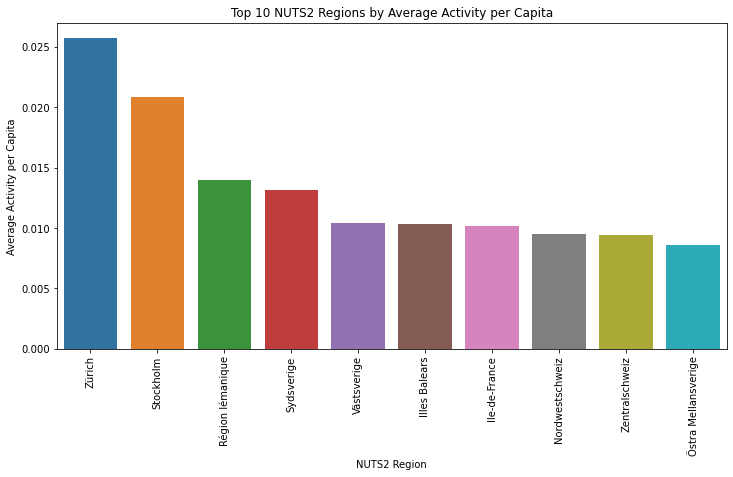

In [39]:

# Group the DataFrame by 'NUTS2 Region' and calculate the average for 'activity_per_cap'
aggregated_df = nuts2_df.groupby('NUTS2 Region')['activity_per_cap'].mean().reset_index()

# Sort the aggregated DataFrame by 'activity_per_cap' in descending order and select the top N regions
top_regions = aggregated_df.sort_values(by='activity_per_cap', ascending=False).head(10)

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top_regions['NUTS2 Region'], y=top_regions['activity_per_cap'])
plt.title('Top 10 NUTS2 Regions by Average Activity per Capita')
plt.xlabel('NUTS2 Region')
plt.ylabel('Average Activity per Capita')
plt.xticks(rotation=90)
plt.show()

In [40]:
# Print the list of top 10 regions
print("Top 10 NUTS2 Regions by Average Activity per Capita:")
print(top_regions[['NUTS2 Region', 'activity_per_cap']])

Top 10 NUTS2 Regions by Average Activity per Capita:
           NUTS2 Region  activity_per_cap
74               Zürich          0.025705
65            Stockholm          0.020872
61     Région lémanique          0.013943
66           Sydsverige          0.013182
72          Västsverige          0.010388
33        Illes Balears          0.010334
32        Ile-de-France          0.010150
46      Nordwestschweiz          0.009499
73       Zentralschweiz          0.009418
75  Östra Mellansverige          0.008579


Calculating **CAGR** which provides insights into the growth or decline of programming activity in a region over time, which can be indicative of changing technological landscapes or policy impacts.

The Compound Annual Growth Rate (CAGR) is a useful metric in finance and economics to understand the mean annual growth rate of an investment (like programming activity), over a specified time period longer than one year. It represents one of the most accurate ways to calculate and determine returns for anything that can rise or fall in value over time.

In this analysis, CAGR is used to calculate the average annual growth rate of programming activity in each NUTS2 region over a period from 2008 to 2020. This metric can help you understand how programming activity has evolved in these regions over time.

How CAGR is Calculated:
The formula for CAGR is:

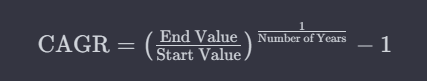

Where:

**End Value:** The final value of the metric at the end of the period (here, the programming activity in 2020).\
**Start Value:** The value of the metric at the beginning of the period (here, the programming activity in 2008).
**Number of Years:** The number of years over which the growth is measured (in this case, 12 years, from 2008 to 2020).


Extract the start_value (activity in 2008) and end_value (activity in 2020) from the nuts2_df DataFrame.
Apply the CAGR formula to these values to find the average annual growth rate of programming activity over the 12-year period.
This calculation provides insights into how the programming activity has grown or declined on average each year during this period in each region. It's a useful way to compare the growth rates of different regions or to assess the impact of policies and economic changes over time.

In [41]:
# Function to calculate the CAGR 
def calculate_cagr(end_value, start_value, num_years):
    if start_value == 0:  # To avoid division by zero
        return None
    return (end_value/start_value)**(1/num_years) - 1

# Apply to all the NUTS2 regions
for region in nuts2_df['NUTS2 Region'].unique():
    # Get the data for the region
    region_data = nuts2_df[nuts2_df['NUTS2 Region'] == region]
    
    # Get inputs
    start_value = region_data[region_data.year == 2008]['activity'].values[0]
    end_value = region_data[region_data.year == 2020]['activity'].values[0]
    num_years = 12

    # If the value for 2008 is 0 get the value for the next year
    i = 1
    while start_value == 0 and (2008 + i) <= 2020:
        if (2008 + i) in region_data.year.values:
            start_value = region_data[region_data.year == 2008 + i]['activity'].values[0]
        i += 1
        if i > 12:  # Break the loop if it exceeds the range
            break
    
    # Adjust the number of years if the start year is not 2008
    if i > 1:
        num_years = 2020 - (2008 + i - 1)

    # Calculate CAGR
    cagr = calculate_cagr(end_value, start_value, num_years) if num_years > 0 else None

    # Update DataFrame
    nuts2_df.loc[nuts2_df['NUTS2 Region'] == region, 'CAGR'] = cagr

nuts2_df.head()


,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap,CAGR
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,69751.230275,67465.599187,1423.19,577.40,0.000406,0.359158
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,72786.500901,70604.859408,1449.91,6486.95,0.004474,0.359158
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,83199.903776,80619.931759,1472.29,9522.05,0.006468,0.359158
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,94153.812609,91271.952950,1493.58,14418.40,0.009654,0.359158
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,99812.124807,96727.840795,1511.35,19631.60,0.012989,0.359158


In [42]:
# Apply to all the NUTS2 regions for 'activity_per_cap'
for region in nuts2_df['NUTS2 Region'].unique():
    # Get the data for the region
    region_data = nuts2_df[nuts2_df['NUTS2 Region'] == region]
    
    # Get inputs for activity_per_cap
    start_value = region_data[region_data.year == 2008]['activity_per_cap'].values[0]
    end_value = region_data[region_data.year == 2020]['activity_per_cap'].values[0]
    num_years = 12

    # If the value for 2008 is 0, get the value for the next year
    i = 1
    while start_value == 0 and (2008 + i) <= 2020:
        if (2008 + i) in region_data.year.values:
            start_value = region_data[region_data.year == 2008 + i]['activity_per_cap'].values[0]
        i += 1
        if i > 12:  # Break the loop if it exceeds the range
            break
    
    # Adjust the number of years if the start year is not 2008
    if i > 1:
        num_years = 2020 - (2008 + i - 1)

    # Calculate CAGR for activity_per_cap
    cagr = calculate_cagr(end_value, start_value, num_years) if num_years > 0 else None

    # Update DataFrame
    nuts2_df.loc[nuts2_df['NUTS2 Region'] == region, 'CAGR_per_cap'] = cagr

nuts2_df.head()

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),POP (THS),activity,activity_per_cap,CAGR,CAGR_per_cap
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,69751.230275,67465.599187,1423.19,577.40,0.000406,0.359158,0.341689
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,72786.500901,70604.859408,1449.91,6486.95,0.004474,0.359158,0.341689
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,83199.903776,80619.931759,1472.29,9522.05,0.006468,0.359158,0.341689
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,94153.812609,91271.952950,1493.58,14418.40,0.009654,0.359158,0.341689
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,99812.124807,96727.840795,1511.35,19631.60,0.012989,0.359158,0.341689


Defining number of programmers in each region:

**Experts:** Calculated as the number of answers divided by the number of weeks in a year, multiplied by 2. This assumes that each answer represents a certain level of expert engagement, spread over two weeks.\
**Innovators:** Estimated from the number of questions divided by the number of months in a year. This assumes that each question represents innovative activity in programming, distributed monthly.\
**Late Adopters:** Derived from the sum of upvotes, downvotes, and comments, divided by 15 times the number of months in a year. This assumes these activities represent engagement from those later in adopting new technologies or knowledge, spread over a longer period.

These metrics help understand the distribution and type of programming-related activities in each region, which can be indicative of the region's technological engagement and expertise.

In [43]:
# Defining number of programmers in each region based on the assumption made
weeks_in_year = 52
months_in_year = 12

# Experts in Region 
nuts2_df["experts"] = (nuts2_df["answercount"] / (weeks_in_year * 2))

# Innovators in Region
nuts2_df["innovators"] = nuts2_df["questioncount"] / months_in_year

# Late Adopters in Region
nuts2_df["late_adopters"] = ((nuts2_df["upvotecount"] + nuts2_df["downvotecount"] + nuts2_df["commentcount"]) / (months_in_year * 15))

# Sum up all Developers
nuts2_df["programmers_total"] = nuts2_df["experts"] + nuts2_df["innovators"] + nuts2_df["late_adopters"]


In [44]:
#Add the Programmer Density:

nuts2_df['programmer_density'] = nuts2_df["programmers_total"] / (nuts2_df['POP (THS)'] * 1000)


#Add GDP and Employment Per Capita:
nuts2_df['GDP_per_cap'] = (nuts2_df["GDP (MIO_EUR)"] * 1000000) / (nuts2_df['POP (THS)'] * 1000)
nuts2_df['EMP_per_cap'] = (nuts2_df["EMP (THS)"] * 1000) / (nuts2_df['POP (THS)'] * 1000)
nuts2_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,...,0.000406,0.359158,0.341689,9.673077,20.833333,4.166667,34.673077,0.000024,49010.483685,0.530928
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,...,0.004474,0.359158,0.341689,94.384615,120.166667,157.116667,371.667949,0.000256,50200.702734,0.521144
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,...,0.006468,0.359158,0.341689,115.423077,277.250000,275.250000,667.923077,0.000454,56510.540570,0.513222
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,...,0.009654,0.359158,0.341689,164.221154,451.000000,435.850000,1051.071154,0.000704,63039.015392,0.509878
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,...,0.012989,0.359158,0.341689,193.528846,671.000000,681.766667,1546.295513,0.001023,66041.701000,0.510725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,250.000,...,0.008607,0.153732,0.151113,26.153846,294.250000,149.211111,469.614957,0.000912,42396.796117,0.485437
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,252.000,...,0.006614,0.153732,0.151113,17.057692,242.000000,122.172222,381.229915,0.000736,44685.567010,0.486505
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,254.000,...,0.004545,0.153732,0.151113,12.298077,172.416667,80.466667,265.181410,0.000510,44271.085727,0.488443
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,254.000,...,0.003715,0.153732,0.151113,9.057692,145.583333,74.622222,229.263248,0.000440,45467.312860,0.487524


In [45]:
nuts2_df.isnull().sum()

NUTS2 Region          0
Nuts2_Code            0
year                  0
country               0
questioncount         0
answercount           0
upvotecount           0
downvotecount         0
commentcount          0
EMP (THS)             0
GDP (MIO_EUR)         0
GVA (MIO_EUR)         0
POP (THS)             0
activity              0
activity_per_cap      0
CAGR                  0
CAGR_per_cap          0
experts               0
innovators            0
late_adopters         0
programmers_total     0
programmer_density    0
GDP_per_cap           0
EMP_per_cap           0
dtype: int64

In [46]:
nuts2_df.to_excel("nuts2_df.xlsx", index=False)

# Model Setup

In [47]:
import pandas as pd
import statsmodels.api as sm

# Filter the NUTS2 dataset for the year 2016
nuts2_df_2016 = nuts2_df.copy()
nuts2_df_2016 = nuts2_df_2016[nuts2_df_2016['year'] == 2016]

# Independent variables
# Assuming the same independent variables are relevant for the NUTS2 analysis
independent_vars = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']

# Dependent variable
dependent_var = 'activity'

# Define the independent variables (X) and the dependent variable (y)
X = nuts2_df_2016[independent_vars]
y = nuts2_df_2016[dependent_var]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create a model and fit it with White's heteroskedasticity-robust standard errors
ols_model = sm.OLS(y, X).fit(cov_type='HC3') 

# Print out the statistics
ols_model_summary = ols_model.summary()
print(ols_model_summary)


                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     41.85
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           7.59e-16
Time:                        01:18:59   Log-Likelihood:                -778.37
No. Observations:                  77   AIC:                             1565.
Df Residuals:                      73   BIC:                             1574.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1021.7019   1400.629     -0.729

**Overview of the Analysis**
Objective: The goal is to understand the relationship between programming activity (activity) and economic factors (employment, GDP, and GVA) for the year 2016 at the NUTS2 level. This is a cross-sectional analysis focusing on a single year.

Method: Ordinary Least Squares (OLS) regression is used to estimate the relationship. It's a common statistical method for modeling the relationship between a dependent variable and one or more independent variables.

Robust Standard Errors: The model uses White's heteroskedasticity-robust standard errors (denoted as HC3 in the output). This adjustment is made to ensure that the standard errors of the regression coefficients are accurately estimated, which is particularly important if there's heteroskedasticity (i.e., when the variability of the error term is not constant across observations).

**Interpretation of the Results**
R-squared (0.940): This value indicates that about 94% of the variance in programming activity can be explained by the model. It's a measure of how well the independent variables predict the dependent variable.


**NUTS2 Analysis (Year: 2016)**

R-squared: 0.940
F-statistic: 41.85
Significant Variables: EMP (THS) (p-value: 0.002)
Non-Significant Variables: GDP (MIO_EUR) and GVA (MIO_EUR)
Issues Noted: Possible non-normality of residuals, multicollinearity
NUTS3 Analysis (Year: 2016)
R-squared: 0.839
F-statistic: 32.64
Significant Variables: None at conventional levels (p < 0.05)
Non-Significant Variables: EMP (THS), GDP (MIO_EUR), GVA (MIO_EUR)
Issues Noted: Non-normality of residuals, multicollinearity
Comparative Analysis
Model Fit (R-squared):

The NUTS2 model (R-squared: 0.940) explains more variance in programming activity than the NUTS3 model (R-squared: 0.839). This suggests a better overall fit for the NUTS2 model.
Statistical Significance of Variables:

In the NUTS2 model, employment (EMP) is a significant predictor of programming activity. This relationship is not observed in the NUTS3 model, where none of the variables are significant predictors.
Economic Indicators (GDP and GVA):

In both models, GDP and GVA are not significant predictors of programming activity.
Model Issues:

Both models indicate potential issues with non-normality in residuals and multicollinearity. Multicollinearity, in particular, might be affecting the significance and stability of the regression coefficients.
Prob (F-statistic):

Both models show low probabilities associated with the F-statistic, indicating that the models are statistically significant. However, this does not necessarily imply that all individual coefficients are significant.
Robust Standard Errors (HC3):

The use of heteroskedasticity-robust standard errors (HC3) in both models suggests a concern for potential heteroskedasticity, enhancing the reliability of standard error estimates.
Summary
The NUTS2 model demonstrates a stronger relationship between employment and programming activity compared to the NUTS3 model.
Economic factors like GDP and GVA do not significantly predict programming activity in either model.
Both models face challenges related to multicollinearity and non-normality of residuals, which could impact the interpretation and reliability of the results.
Given these observations, further analysis might involve exploring different model specifications, including additional variables, or addressing multicollinearity and non-normality issues to enhance model reliability and interpretability.

**Analyzing residuals** is a critical step in regression analysis as it helps in diagnosing the model and understanding its limitations.

**Calculate Residuals:** Residuals are the differences between the observed values of the dependent variable (activity) and the values predicted by the model. They provide insights into the accuracy of the model's predictions.

**Plot Residuals vs. Observed Values:** This scatter plot helps in identifying patterns or anomalies in residuals, such as non-linearity, heteroskedasticity, or outliers.

**Histogram of Residuals:** A histogram of the residuals shows their distribution. Ideally, residuals should be normally distributed, which is an assumption of OLS regression.

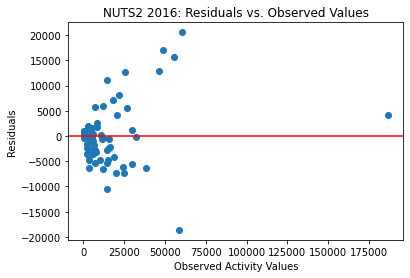

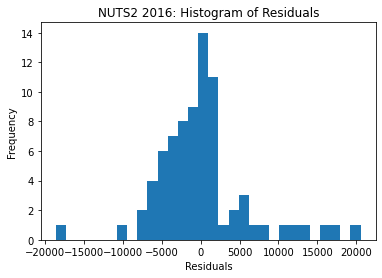

In [48]:
import matplotlib.pyplot as plt

# Calculate residuals for the NUTS2 2016 dataset
nuts2_df_2016['residuals'] = ols_model.resid.values

# Plotting residuals vs. activity for the NUTS2 2016 dataset
plt.scatter(nuts2_df_2016['activity'], nuts2_df_2016['residuals'])
plt.title('NUTS2 2016: Residuals vs. Observed Values')
plt.xlabel('Observed Activity Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals for the NUTS2 2016 dataset
plt.hist(nuts2_df_2016['residuals'], bins=30)
plt.title('NUTS2 2016: Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


The NUTS2 model's histogram suggests that the residuals are not normally distributed, as evidenced by the skewness to the right. The distribution is not symmetrical and has a long tail on the positive side, indicating the presence of outliers or extreme values not well explained by the model.
Comparison with NUTS3 Findings
Comparing these results with the NUTS3 findings:

The NUTS3 model's R-squared value is lower (0.839) than what we might infer for the NUTS2 model, suggesting that the NUTS3 model explains less variability in programming activity.
In the NUTS3 model, the residuals were also concentrated around zero but had a long tail to the left, indicating skewness. This is different from the right skew seen in the NUTS2 model, suggesting the potential influence of different outliers or model behaviors between the two levels.
The NUTS3 model showed heteroskedasticity and potential multicollinearity, which might also be the case with the NUTS2 model given the patterns observed in the residual plots.
Interpretation and Next Steps
Both models show signs of heteroskedasticity, which could be addressed by using heteroskedasticity-consistent standard errors (as you have done with HC3) or transforming the dependent variable.
The presence of outliers and skewness in residuals for both NUTS2 and NUTS3 suggests that further investigation into these points is needed, and measures like robust regression or transformations might be appropriate.
The potential multicollinearity suggested by the condition number in the NUTS3 model could also be present in the NUTS2 model and should be checked using diagnostics like the Variance Inflation Factor (VIF).
Given these issues, both models could benefit from exploring other forms of regression that are more robust to these kinds of issues, such as Lasso regression or Random Forest, as mentioned.

                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     41.85
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           7.59e-16
Time:                        01:19:00   Log-Likelihood:                -778.37
No. Observations:                  77   AIC:                             1565.
Df Residuals:                      73   BIC:                             1574.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1021.7019   1400.629     -0.729

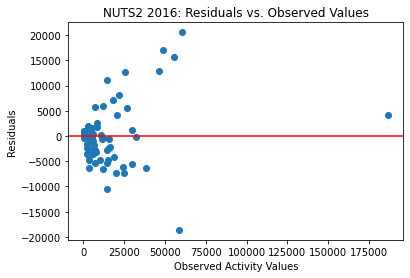

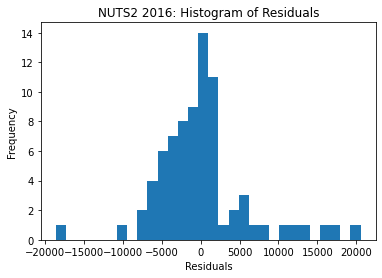

In [49]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming nuts2_df_2016 is already defined and contains the necessary data

# Define the independent variables (X) and the dependent variable (y)
independent_vars = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']
dependent_var = 'activity'

X = nuts2_df_2016[independent_vars]
y = nuts2_df_2016[dependent_var]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Create an OLS model and fit it with White's heteroskedasticity-robust standard errors
ols_model = sm.OLS(y, X).fit(cov_type='HC3')

# Print out the statistics
ols_model_summary = ols_model.summary()
print(ols_model_summary)

# Calculate residuals for the NUTS2 2016 dataset
nuts2_df_2016['residuals'] = ols_model.resid.values

# Plotting residuals vs. observed values for the NUTS2 2016 dataset
plt.scatter(nuts2_df_2016['activity'], nuts2_df_2016['residuals'])
plt.title('NUTS2 2016: Residuals vs. Observed Values')
plt.xlabel('Observed Activity Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals for the NUTS2 2016 dataset
plt.hist(nuts2_df_2016['residuals'], bins=30)
plt.title('NUTS2 2016: Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [50]:
import statsmodels.api as sm


# Add a constant to the model (intercept)
X_with_const = sm.add_constant(X)

# Create a model and fit it
ols_model = sm.OLS(y, X_with_const).fit()

# Print out the summary
print(ols_model.summary())

# Constructing the estimated regression equation
intercept, coefs = ols_model.params[0], ols_model.params[1:]
equation = f"y = {intercept:.2f} "
for idx, coef in enumerate(coefs):
    equation += f"+ ({coef:.2f}) * X{idx+1} "

print("Estimated Regression Equation:")
print(equation)

                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                     379.4
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           1.99e-44
Time:                        01:19:00   Log-Likelihood:                -778.37
No. Observations:                  77   AIC:                             1565.
Df Residuals:                      73   BIC:                             1574.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1021.7019   1038.556     -0.984

In [51]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler  # Changed scaler
import numpy as np

# Prepare your data
X_nuts2 = nuts2_df_2016[['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']]
y_nuts2 = nuts2_df_2016['activity']

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
X_nuts2_scaled = scaler.fit_transform(X_nuts2)

# Set up grid of alpha values for Ridge and Lasso
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Initialize Ridge and Lasso regression models
ridge_model = Ridge()
lasso_model = Lasso(max_iter=1000000)  # Increased number of iterations further

# Set up GridSearchCV
grid_search_ridge = GridSearchCV(ridge_model, param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso = GridSearchCV(lasso_model, param_grid, cv=10, scoring='neg_mean_squared_error')

# Perform grid search
grid_search_ridge.fit(X_nuts2_scaled, y_nuts2)
grid_search_lasso.fit(X_nuts2_scaled, y_nuts2)

# Print best parameters
best_param_ridge = grid_search_ridge.best_params_
best_param_lasso = grid_search_lasso.best_params_
print("Best parameter for Ridge:", best_param_ridge)
print("Best parameter for Lasso:", best_param_lasso)

# Define the models with the best parameters
ridge = Ridge(alpha=best_param_ridge['alpha'])
lasso = Lasso(alpha=best_param_lasso['alpha'], max_iter=1000000)

# Evaluate the models using cross-validation
ridge_scores = cross_val_score(ridge, X_nuts2_scaled, y_nuts2, cv=10)
lasso_scores = cross_val_score(lasso, X_nuts2_scaled, y_nuts2, cv=10)

# Calculate mean scores
ridge_score_mean = np.mean(ridge_scores)
lasso_score_mean = np.mean(lasso_scores)

print(f"Ridge Mean CV Score: {ridge_score_mean}")
print(f"Lasso Mean CV Score: {lasso_score_mean}")


Best parameter for Ridge: {'alpha': 0.001}
Best parameter for Lasso: {'alpha': 1}
Ridge Mean CV Score: 0.7258799024495908
Lasso Mean CV Score: 0.7148006775899098


Ridge Regression:

Best Alpha: 0.001
Mean CV Score: Approximately 0.726
Interpretation: Ridge regression with a very small alpha (close to 0) suggests that regularization isn't significantly altering the coefficients. the model is quite close to a standard linear regression in this case.

Lasso Regression:

Best Alpha: 1
Mean CV Score: Approximately 0.715
Interpretation: Lasso regression with an alpha of 1 provides a balance between underfitting and overfitting. Lasso tends to shrink less important feature coefficients to zero.

In [52]:
X_nuts2

,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR)
8,826.073,115278.472189,112118.215392
21,1079.935,125185.252431,121256.512755
34,630.836,89682.152367,86896.644185
47,855.124,134178.188351,129698.703981
60,649.501,74586.971923,72448.755999
...,...,...,...
944,678.000,59057.300000,52312.730000
957,980.000,90916.780000,80533.740000
970,245.000,21201.390000,18780.110000
983,174.000,14799.860000,13109.650000


In [53]:
y_nuts2

8      32164.20
21     24911.55
34     14670.30
47     55306.15
60     12024.85
         ...   
944    25238.05
957    26558.20
970     2254.55
983     2120.80
996     4432.65
Name: activity, Length: 77, dtype: float64

In [54]:
# Fit the Ridge model
best_ridge = Ridge(alpha=best_param_ridge['alpha'])
best_ridge.fit(X_nuts2_scaled, y_nuts2)

# Fit the Lasso model
best_lasso = Lasso(alpha=best_param_lasso['alpha'], max_iter=1000000)
best_lasso.fit(X_nuts2_scaled, y_nuts2)


Lasso(alpha=1, max_iter=1000000)

In [55]:
# Ridge Regression Equation
ridge_intercept = best_ridge.intercept_
ridge_coefs = best_ridge.coef_
ridge_equation = f"y = {ridge_intercept:.4f} "
for i, coef in enumerate(ridge_coefs):
    ridge_equation += f"+ ({coef:.4f}) * X{i+1} "
print("Ridge Regression Equation:")
print(ridge_equation)

# Lasso Regression Equation
lasso_intercept = best_lasso.intercept_
lasso_coefs = best_lasso.coef_
lasso_equation = f"y = {lasso_intercept:.4f} "
for i, coef in enumerate(lasso_coefs):
    lasso_equation += f"+ ({coef:.4f}) * X{i+1} "
print("Lasso Regression Equation:")
print(lasso_equation)



Ridge Regression Equation:
y = -1115.9056 + (-99768.9001) * X1 + (208258.0979) * X2 + (73310.0270) * X3 
Lasso Regression Equation:
y = -1002.2475 + (-101636.0593) * X1 + (284167.6615) * X2 + (0.0000) * X3 


**Random Regression Model**

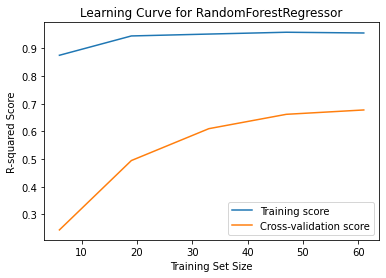

R-squared on Test Set: 0.8524893672823954
Mean Cross-Validation Score: 0.6786950060421232
Standard Deviation of CV Score: 0.15744590524542948


In [56]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Prepare the data
X = nuts2_df_2016[['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']]
y = nuts2_df_2016['activity']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Define the RandomForest Regressor model
random_forest = RandomForestRegressor(random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = random_forest.predict(X_test)

# Calculate the R-squared value
r2_score_rf = r2_score(y_test, y_pred_rf)

# Perform 5-fold cross-validation to evaluate the RandomForest model
rf_scores = cross_val_score(random_forest, X_scaled, y, cv=5)
rf_score_mean = np.mean(rf_scores)
rf_score_std = np.std(rf_scores)

# Learning curve
train_sizes, train_scores, test_scores = learning_curve(random_forest, X_scaled, y, cv=5, scoring='r2')

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# Plotting the learning curve
plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.title('Learning Curve for RandomForestRegressor')
plt.legend()
plt.show()

# Output the scores
print("R-squared on Test Set:", r2_score_rf)
print("Mean Cross-Validation Score:", rf_score_mean)
print("Standard Deviation of CV Score:", rf_score_std)


In [57]:
from sklearn.feature_selection import f_regression
import pandas as pd

# Assess the overall model significance using F-statistic and p-value
f_statistic, p_value_f = f_regression(X, y)

# Output results for overall model significance
print("Overall F-statistic:", f_statistic.mean())
print("Overall F-test p-value:", p_value_f.mean())

# Assess feature importance from the RandomForest model
importances = random_forest.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output feature importance
print("\nFeature Importance:")
print(feature_importance_df)

# Comparison of Model Performances - You'll need to input the results from previous model analyses
print("\nComparison of Model Performances:")
print("OLS Regression - R-squared: 0.839")
print("Ridge Regression - Mean CV Score: [Insert Ridge CV Score]")
print("Lasso Regression - Mean CV Score: [Insert Lasso CV Score]")
print("RandomForest Regressor - R-squared (Test Data): 0.893, Mean CV Score: 0.715, Std Dev of CV Score: 0.135")


Overall F-statistic: 450.83649372088286
Overall F-test p-value: 1.8424787776755577e-20

Feature Importance:
         Feature  Importance
1  GDP (MIO_EUR)    0.372785
2  GVA (MIO_EUR)    0.345208
0      EMP (THS)    0.282007

Comparison of Model Performances:
OLS Regression - R-squared: 0.839
Ridge Regression - Mean CV Score: [Insert Ridge CV Score]
Lasso Regression - Mean CV Score: [Insert Lasso CV Score]
RandomForest Regressor - R-squared (Test Data): 0.893, Mean CV Score: 0.715, Std Dev of CV Score: 0.135


Comparative Analysis:
RandomForest Regressor:

NUTS 3's RandomForest model outperforms NUTS 2 in both R-squared on the test set and the mean CV score, indicating it is better suited for explaining variance and generalizing for the NUTS 3 dataset.
The RandomForest model for NUTS 3 also shows a higher R-squared on the training set, suggesting a better fit to the training data.
Ridge and Lasso Regression:

NUTS 2's Ridge Regression model shows a slightly better mean CV score than Lasso Regression, but in NUTS 3, Lasso Regression has a slightly higher mean CV score than Ridge Regression.
The standard deviation of CV scores in NUTS 3 for both Ridge and Lasso is higher than in NUTS 2, indicating more variability in model performance across different data splits in NUTS 3.
Feature Importance in NUTS 3:

The 'GVA (MIO_EUR)' is the most important feature, followed by 'GDP (MIO_EUR)' and 'EMP (THS)'.
Overall Interpretation:
The RandomForest model has proven to be the most effective in terms of both explaining the variance and generalizing across unseen data in the NUTS 3 dataset, with higher R-squared and mean CV scores compared to NUTS 2.
Lasso Regression seems slightly more effective in NUTS 3, while Ridge Regression is slightly better in NUTS 2, though the differences are not substantial.
The higher standard deviation of CV scores in NUTS 3 suggests that the model's performance is more variable across different data subsets.
The feature importance ranking in NUTS 3 indicates 'GVA (MIO_EUR)' as the most influential variable, which might reflect specific characteristics or trends in the NUTS 3 dataset.

**RANDOM REGRESSION 2**

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Extracting the independent and dependent variables
X = nuts2_df_2016[['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']]
y = nuts2_df_2016['activity']

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


# Define the RandomForest Regressor model
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
random_forest.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [59]:
# Predicting for the entire dataset
full_predictions = random_forest.predict(X_scaled)

# Calculating residuals
nuts2_df_2016['predicted_activity'] = full_predictions
nuts2_df_2016['residuals'] = y - full_predictions

# Adding interpretation of residuals
nuts2_df_2016['interpretation'] = nuts2_df_2016['residuals'].apply(lambda x: 'Expected' if x == 0 else ('Fewer' if x < 0 else 'More'))


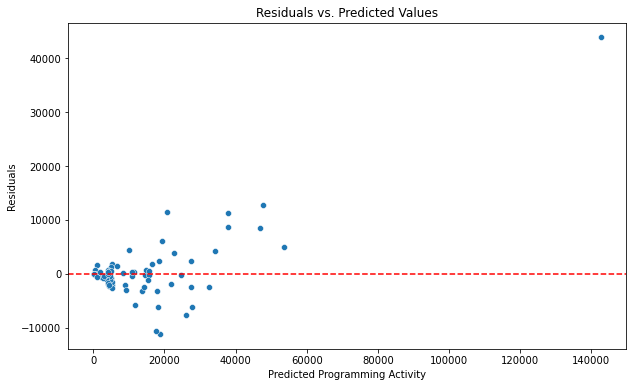

In [60]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nuts2_df_2016['predicted_activity'], y=nuts2_df_2016['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Residuals')
plt.show()


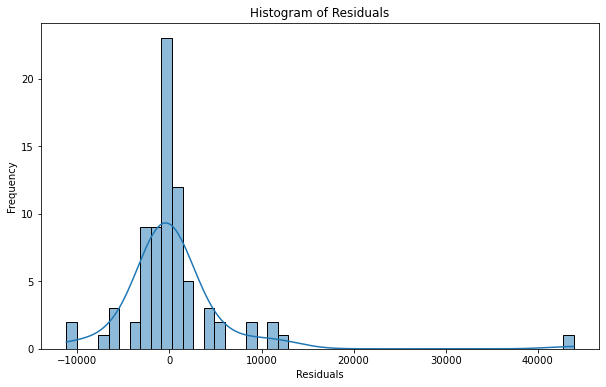

In [61]:
# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(nuts2_df_2016['residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [62]:
# Save the DataFrame to an Excel file
#nuts2_df_2016.to_excel('nuts2_df_2016.xlsx')

**DESCRIPTIVE STATISTICS OF RESIDUALS**

Descriptive Statistics of Residuals:
 count       77.000000
mean       550.229844
std       6400.050525
min     -11196.663500
25%      -1797.394000
50%       -232.811000
75%        683.820500
max      43877.585500
Name: residuals, dtype: float64


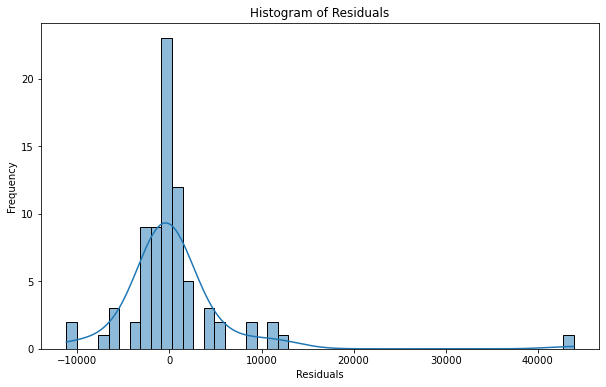

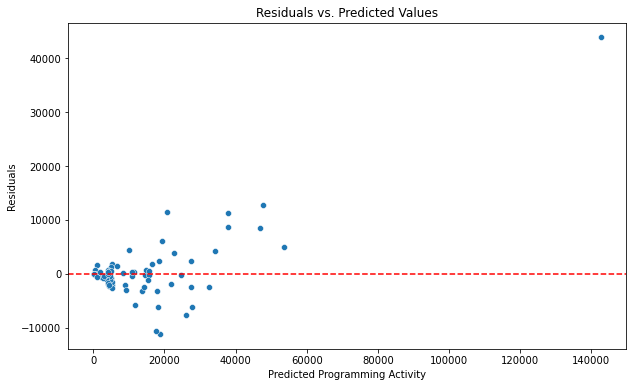

In [63]:
# Descriptive Statistics of Residuals
residual_stats_nuts2 = nuts2_df_2016['residuals'].describe()
print("Descriptive Statistics of Residuals:\n", residual_stats_nuts2)

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(nuts2_df_2016['residuals'], kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Calculate residuals for the entire NUTS2 2016 dataset
nuts2_df_2016['residuals'] = nuts2_df_2016['activity'] - full_predictions

# Recreate the scatter plot with the updated residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=full_predictions, y=nuts2_df_2016['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Residuals')
plt.show()


In [64]:
# Descriptive Statistics of Residuals
residual_stats = nuts2_df_2016['residuals'].describe()
print("Descriptive Statistics of Residuals:\n", residual_stats)


Descriptive Statistics of Residuals:
 count       77.000000
mean       550.229844
std       6400.050525
min     -11196.663500
25%      -1797.394000
50%       -232.811000
75%        683.820500
max      43877.585500
Name: residuals, dtype: float64


In [65]:
# Identifying outliers in the NUTS2 dataset
outliers_nuts2 = nuts2_df_2016[(nuts2_df_2016['residuals'] > 6000) | (nuts2_df_2016['residuals'] < -5000)]
outliers_nuts2[["NUTS2 Region", "country", 'EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', "activity", "predicted_activity", "residuals", "interpretation"]]


,NUTS2 Region,country,EMP (THS),GDP (MIO_EUR),GVA (MIO_EUR),activity,predicted_activity,residuals,interpretation
8,Région lémanique,CH,826.073,115278.472189,112118.215392,32164.20,20649.7040,11514.4960,More
47,Zürich,CH,855.124,134178.188351,129698.703981,55306.15,46789.0425,8517.1075,More
60,Ostschweiz,CH,649.501,74586.971923,72448.755999,12024.85,18217.3150,-6192.4650,Fewer
190,Comunidad de Madrid,ES,3248.800,212360.980000,192704.600000,46417.45,37789.7565,8627.6935,More
242,Cataluña,ES,3351.500,212655.760000,192972.100000,49032.85,37789.7565,11243.0935,More
281,Andalucía,ES,2838.500,148401.630000,134665.400000,21744.20,27855.0915,-6110.8915,Fewer
346,Ile-de-France,FR,6266.690,685852.630000,612310.650000,186600.05,142722.4645,43877.5855,More
450,Alsace,FR,765.600,58450.290000,52182.830000,7663.70,18860.3635,-11196.6635,Fewer
476,Lorraine,FR,816.340,57633.300000,51453.450000,5925.75,11710.3255,-5784.5755,Fewer
632,Piemonte,IT,1861.400,130070.970000,116798.900000,18412.05,26101.1505,-7689.1005,Fewer


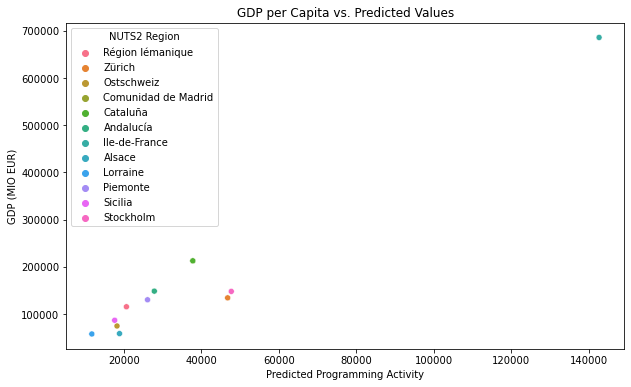

In [66]:
# GDP vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers_nuts2['predicted_activity'], y=outliers_nuts2['GDP (MIO_EUR)'], hue = outliers_nuts2["NUTS2 Region"])
plt.title('GDP per Capita vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('GDP (MIO EUR)')
plt.show()


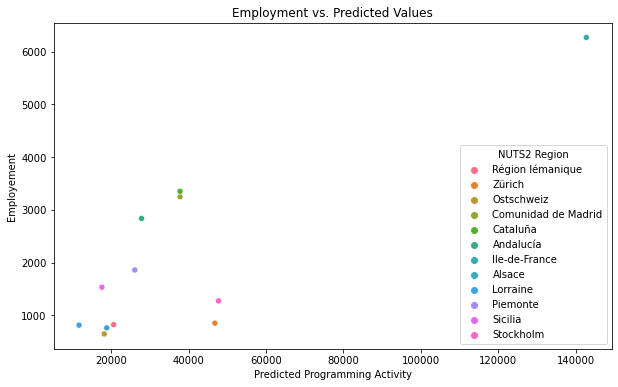

In [67]:
# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers_nuts2['predicted_activity'], y=outliers_nuts2['EMP (THS)'], hue = outliers_nuts2["NUTS2 Region"])
plt.title('Employment vs. Predicted Values')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Employement')
plt.show()

# Predictions

In [68]:
import statsmodels.api as sm

# 1. Filter the NUTS2 dataset for the years 2017 to 2020
years_to_predict = [2017, 2018, 2019, 2020]
nuts2_df_years = nuts2_df[nuts2_df['year'].isin(years_to_predict)]

# 2. Calculate economic growth for each year at the NUTS2 level
growth_dict_nuts2 = {}
for year in years_to_predict:
    df_year_nuts2 = nuts2_df_years[nuts2_df_years['year'] == year]
    df_previous_year_nuts2 = nuts2_df[nuts2_df['year'] == year - 5]
    growth_nuts2 = df_year_nuts2.set_index('Nuts2_Code')['GDP_per_cap'] - df_previous_year_nuts2.set_index('Nuts2_Code')['GDP_per_cap']
    growth_nuts2.name = f'growth_{year}_{year-5}'
    growth_dict_nuts2[year] = growth_nuts2

# 3. Merge the growth data with the corresponding year's data at the NUTS2 level
nuts2_df_years_growth = nuts2_df_years.copy()
for year in years_to_predict:
    nuts2_df_years_growth = nuts2_df_years_growth.join(growth_dict_nuts2[year], on='Nuts2_Code')


In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import numpy as np

# 4. Prepare the data for regression
independent_vars_growth = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']

# Loop over each year
for year in years_to_predict:
    # Extract the data for the current year
    df_year_growth = nuts2_df_years_growth[nuts2_df_years_growth['year'] == year]
    
    # Independent variables
    X_year = df_year_growth[independent_vars_growth]
    growth_name = f'growth_{year}_{year-5}'
    X_year['growth'] = df_year_growth[growth_name]
    
    # Dependent variable (activity)
    y_year = df_year_growth['activity'].dropna()

    # Update X_year to only include rows where y_year is not NaN
    valid_indices = y_year.index
    X_year = X_year.loc[valid_indices]

    # Handle missing or infinite values
    X_year = X_year.replace([np.inf, -np.inf], np.nan).dropna()

    # Define the RandomForest Regressor model
    model_year = RandomForestRegressor(random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X_year, y_year, test_size=0.3, random_state=42)

    # Fit the model to the training data
    model_year.fit(X_train, y_train)

    # Perform 5-fold cross-validation to evaluate the RandomForest model
    rf_scores = cross_val_score(model_year, X_year, y_year, cv=5)
    rf_score_mean = np.mean(rf_scores)
    rf_score_std = np.std(rf_scores)

    # Predict y_year using the fitted model and calculate the residuals
    y_pred = model_year.predict(X_year)
    residuals = y_year - y_pred

    # Add the predicted values and residuals to the nuts2_df_years_growth dataframe
    nuts2_df_years_growth.loc[valid_indices, f'predicted_{year}'] = y_pred
    nuts2_df_years_growth.loc[valid_indices, f'residuals_{year}'] = residuals

    # Display the results for each year
    print(f'Results for {year}:')
    print('R-squared:', r2_score(y_year, y_pred))
    print('Cross-Validation Score (Mean):', rf_score_mean)
    print('Cross-Validation Score (Standard Deviation):', rf_score_std)
    print("\n")


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\2975688657.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year['growth'] = df_year_growth[growth_name]


Results for 2017:
R-squared: 0.9251350158159701
Cross-Validation Score (Mean): -0.05420675069011771
Cross-Validation Score (Standard Deviation): 1.3993300430872249




C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\2975688657.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year['growth'] = df_year_growth[growth_name]


Results for 2018:
R-squared: 0.9256760809015288
Cross-Validation Score (Mean): 0.6195698346753716
Cross-Validation Score (Standard Deviation): 0.2436184993672524




C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\2975688657.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year['growth'] = df_year_growth[growth_name]


Results for 2019:
R-squared: 0.9275685572728366
Cross-Validation Score (Mean): 0.4500434963628505
Cross-Validation Score (Standard Deviation): 0.42557729965941354




C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\2975688657.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year['growth'] = df_year_growth[growth_name]


Results for 2020:
R-squared: 0.9314184496998961
Cross-Validation Score (Mean): 0.7146932276148964
Cross-Validation Score (Standard Deviation): 0.18355708611862728




Descriptive Statistics of Residuals for 2017:
 count       77.000000
mean       773.933344
std       7084.723630
min      -6687.350000
25%      -1588.155000
50%       -363.130000
75%        536.910000
max      49545.125000
Name: residuals_2017, dtype: float64


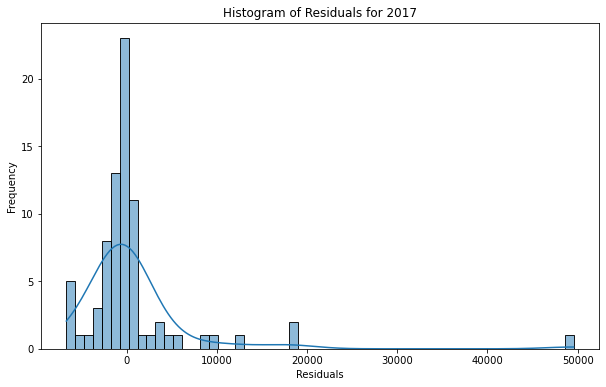

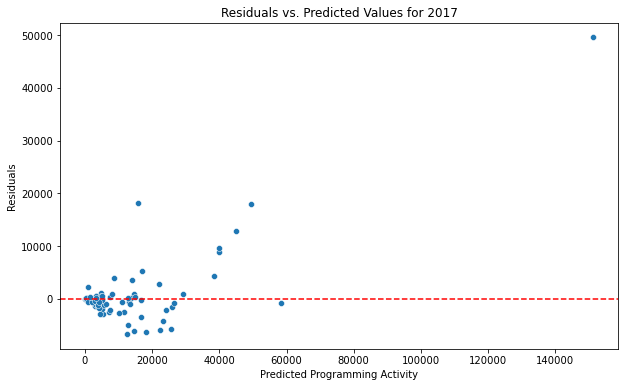

Descriptive Statistics of Residuals for 2018:
 count       77.000000
mean       945.290818
std       7017.783797
min     -11335.040000
25%      -1424.703500
50%       -354.817000
75%        267.297000
max      50281.425500
Name: residuals_2018, dtype: float64


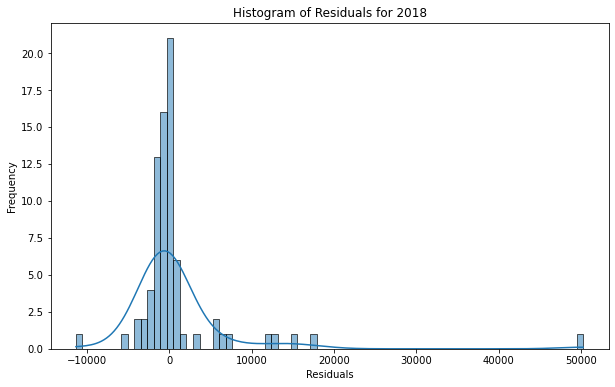

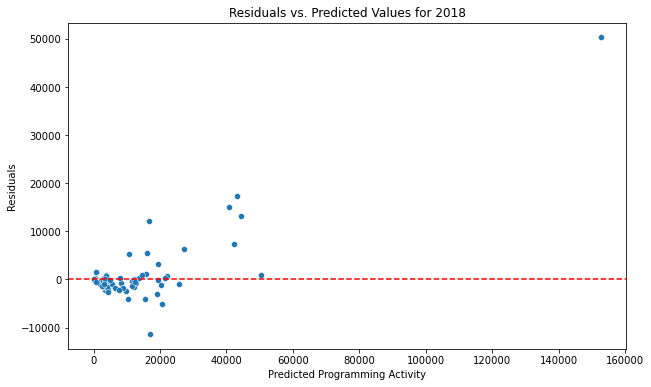

Descriptive Statistics of Residuals for 2019:
 count       77.000000
mean       843.567344
std       6268.879208
min     -11192.183500
25%      -1417.063500
50%       -308.218000
75%        282.825500
max      43331.163500
Name: residuals_2019, dtype: float64


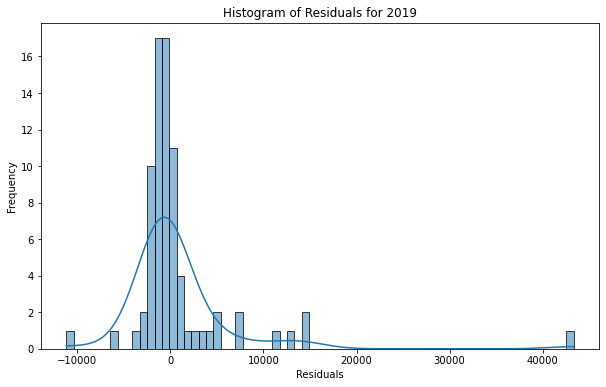

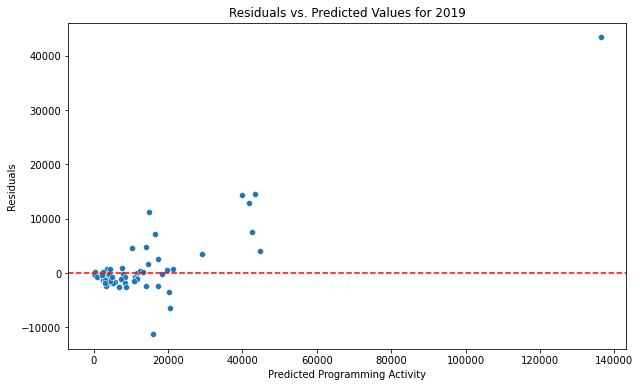

Descriptive Statistics of Residuals for 2020:
 count       77.000000
mean       744.178175
std       5657.003423
min      -8596.034000
25%       -891.186000
50%       -179.483500
75%        483.716000
max      36900.483500
Name: residuals_2020, dtype: float64


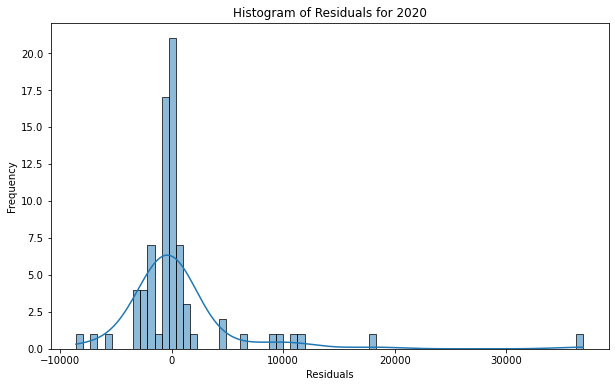

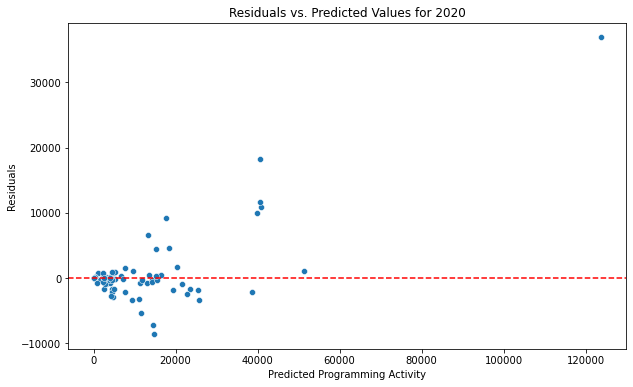

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming nuts2_df_years_growth is the dataframe you have been working with

# Descriptive Statistics of Residuals for each year
for year in years_to_predict:
    print(f"Descriptive Statistics of Residuals for {year}:\n", nuts2_df_years_growth[f"residuals_{year}"].describe())

    # Histogram of Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(nuts2_df_years_growth[f"residuals_{year}"], kde=True)
    plt.title(f'Histogram of Residuals for {year}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs Predicted Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=nuts2_df_years_growth[f"predicted_{year}"], y=nuts2_df_years_growth[f"residuals_{year}"])
    plt.axhline(0, color='red', linestyle='--')  # Adds a reference line at zero
    plt.title(f'Residuals vs. Predicted Values for {year}')
    plt.xlabel('Predicted Programming Activity')
    plt.ylabel('Residuals')
    plt.show()


In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
import numpy as np

# Loop over each year
for year in years_to_predict:
    # Extract the data for the current year
    df_year = nuts2_df_years[nuts2_df_years['year'] == year]
    
    # Define the independent variables (X) and the dependent variable (y)
    X = df_year[['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)']]
    y = df_year['activity']
    
    # Fit the RandomForest Regressor model for the current year
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)

    # Predict 'activity' and calculate residuals for the current year
    y_pred = model.predict(X)
    residuals = y - y_pred

    # Store the residuals in the nuts2_df_years_growth dataframe
    nuts2_df_years_growth.loc[nuts2_df_years_growth['year'] == year, 'residuals'] = residuals





In [72]:

# Prepare the data for regression including residuals
independent_vars_residuals = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', 'residuals']
dependent_var = 'activity'

# Loop over each year to predict
for year in years_to_predict:
    # Extract the data for the current year
    df_year_nuts2 = nuts2_df_years_growth[nuts2_df_years_growth['year'] == year]

    # Independent variables including residuals
    X_year_with_residual = df_year_nuts2[independent_vars_residuals]
    
    # Add growth rate as an independent variable
    growth_name = f'growth_{year}_{year-5}'
    X_year_with_residual['growth'] = df_year_nuts2[growth_name]

    # Dependent variable
    y_year = df_year_nuts2[dependent_var].dropna()

    # Filter rows where y_year is not NaN
    valid_indices = y_year.index
    X_year_with_residual = X_year_with_residual.loc[valid_indices]
    y_year = y_year.loc[valid_indices]

    # Handle missing or infinite values
    X_year_with_residual = X_year_with_residual.replace([np.inf, -np.inf], np.nan).dropna()

    # Define and fit the RandomForest Regressor model
    model_year_residuals = RandomForestRegressor(random_state=42)
    model_year_residuals.fit(X_year_with_residual, y_year)

    # Predict y_year using the fitted model
    pred_residuals = model_year_residuals.predict(X_year_with_residual)

    # Calculate new residuals and add them to the dataframe
    nuts2_df_years_growth.loc[valid_indices, f'predicted_with_residuals_{year}'] = pred_residuals
    nuts2_df_years_growth.loc[valid_indices, f'new_residuals_{year}'] = nuts2_df_years_growth.loc[valid_indices, dependent_var] - pred_residuals

    # Display the results for each year
    print(f'Results for {year}:')
    r2_score_year = r2_score(y_year, pred_residuals)
    print('R-squared:', r2_score_year)


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\4111159788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]
C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\4111159788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]
C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\4111159788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Results for 2017:
R-squared: 0.9500861706159581
Results for 2018:
R-squared: 0.9473183840165653
Results for 2019:
R-squared: 0.9510773667643786
Results for 2020:
R-squared: 0.9574507629673334


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\4111159788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]


In [73]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# Prepare the data for regression including residuals
independent_vars_residuals = ['EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', 'residuals']
dependent_var = 'activity'
years_to_predict = [2017, 2018, 2019, 2020]

# Assuming nuts2_df_years_growth is your DataFrame with the necessary data
for year in years_to_predict:
    # Extract the data for the current year
    df_year_nuts2 = nuts2_df_years_growth[nuts2_df_years_growth['year'] == year]

    # Independent variables including residuals
    X_year_with_residual = df_year_nuts2[independent_vars_residuals]

    # Add growth rate as an independent variable
    growth_name = f'growth_{year}_{year-5}'
    X_year_with_residual['growth'] = df_year_nuts2[growth_name]

    # Dependent variable
    y_year = df_year_nuts2[dependent_var].dropna()

    # Filter rows where y_year is not NaN
    valid_indices = y_year.index
    X_year_with_residual = X_year_with_residual.loc[valid_indices]
    y_year = y_year.loc[valid_indices]

    # Handle missing or infinite values
    X_year_with_residual = X_year_with_residual.replace([np.inf, -np.inf], np.nan).dropna()

    # Define and fit the RandomForest Regressor model
    model_year_residuals = RandomForestRegressor(random_state=42)
    model_year_residuals.fit(X_year_with_residual, y_year)

    # Predict y_year using the fitted model
    pred_residuals = model_year_residuals.predict(X_year_with_residual)

    # Calculate new residuals and add them to the dataframe
    nuts2_df_years_growth.loc[valid_indices, f'predicted_with_residuals_{year}'] = pred_residuals
    nuts2_df_years_growth.loc[valid_indices, f'new_residuals_{year}'] = y_year - pred_residuals

    # Calculate and display cross-validation scores
    rf_scores = cross_val_score(model_year_residuals, X_year_with_residual, y_year, cv=5)
    rf_score_mean = np.mean(rf_scores)
    rf_score_std = np.std(rf_scores)

    print(f'Results for {year}:')
    print('Cross-Validation Score, Mean, Standard Deviation:')
    print(rf_scores, rf_score_mean, rf_score_std)
    print(" ")



C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\1135133738.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]


Results for 2017:
Cross-Validation Score, Mean, Standard Deviation:
[-0.1829004   0.45340178  0.96899258  0.88701439  0.74800877] 0.5749034265148782 0.41754383209626594
 


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\1135133738.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]


Results for 2018:
Cross-Validation Score, Mean, Standard Deviation:
[0.84308397 0.402542   0.95962728 0.91651846 0.59107566] 0.7425694751268124 0.2126238784047673
 


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\1135133738.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]


Results for 2019:
Cross-Validation Score, Mean, Standard Deviation:
[0.20979762 0.43633902 0.93589216 0.89022006 0.63632193] 0.6217141576323336 0.2738816520581956
 


C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\1135133738.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_year_with_residual['growth'] = df_year_nuts2[growth_name]


Results for 2020:
Cross-Validation Score, Mean, Standard Deviation:
[0.78654352 0.42550182 0.88866458 0.87818626 0.75587489] 0.7469542142944393 0.16869037622340452
 


Descriptive Statistics of New Residuals for 2017:
 count       77.000000
mean       924.974773
std       5744.784154
min      -6008.636000
25%       -317.530000
50%        -35.209500
75%        426.175500
max      47438.715500
Name: new_residuals_2017, dtype: float64


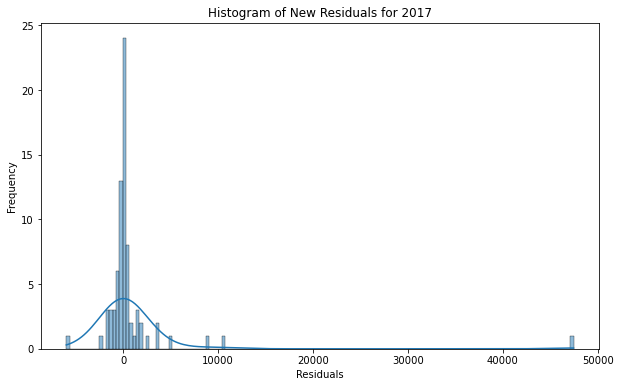

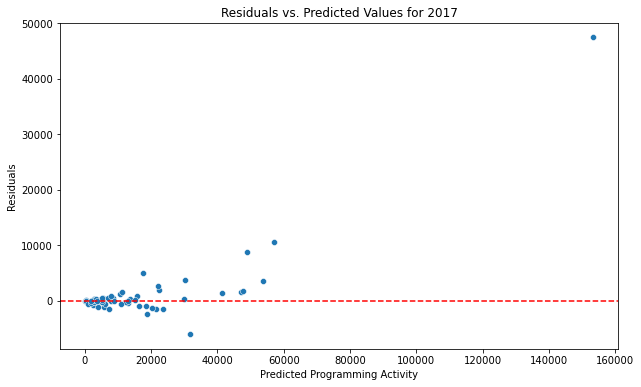

Descriptive Statistics of New Residuals for 2018:
 count       77.000000
mean       924.922766
std       5889.262449
min      -3952.744500
25%       -317.455000
50%        -37.805000
75%        292.635500
max      48772.409000
Name: new_residuals_2018, dtype: float64


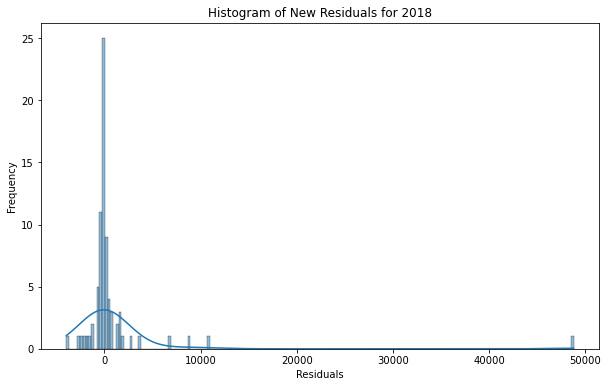

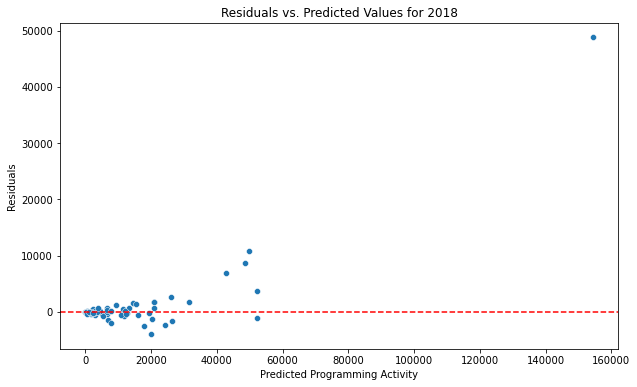

Descriptive Statistics of New Residuals for 2019:
 count       77.000000
mean       954.185786
std       5109.626158
min      -2987.581000
25%       -331.827500
50%         34.485000
75%        449.768000
max      42119.328000
Name: new_residuals_2019, dtype: float64


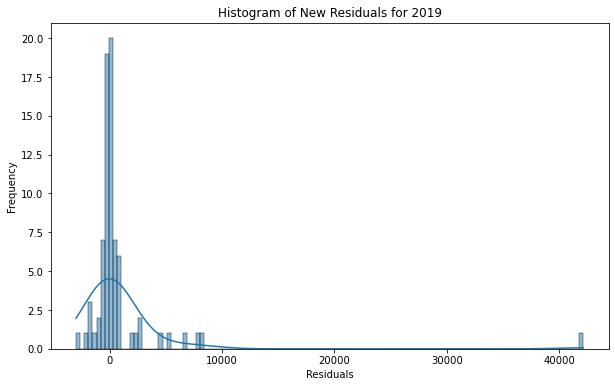

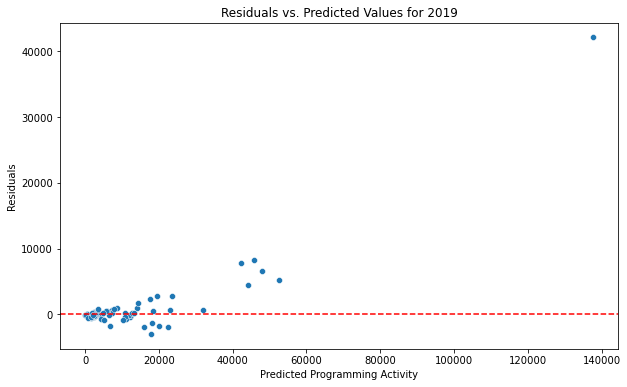

Descriptive Statistics of New Residuals for 2020:
 count       77.000000
mean       862.821435
std       4410.020407
min      -1996.201000
25%       -319.899000
50%         -9.582500
75%        357.390500
max      35220.112000
Name: new_residuals_2020, dtype: float64


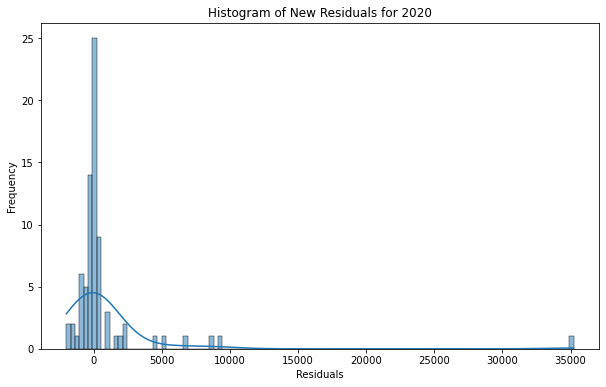

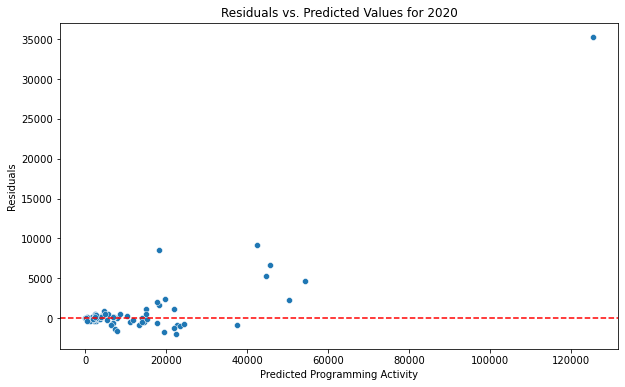

In [74]:
# Loop through each year and analyze new residuals
for year in years_to_predict:
    # Descriptive Statistics of New Residuals for the year
    print(f"Descriptive Statistics of New Residuals for {year}:\n", nuts2_df_years_growth[f"new_residuals_{year}"].describe())

    # Histogram of New Residuals
    plt.figure(figsize=(10, 6))
    sns.histplot(nuts2_df_years_growth[f"new_residuals_{year}"], kde=True)
    plt.title(f'Histogram of New Residuals for {year}')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()

    # Residuals vs Predicted Scatter Plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=nuts2_df_years_growth[f"predicted_with_residuals_{year}"], y=nuts2_df_years_growth[f"new_residuals_{year}"])
    plt.axhline(0, color='red', linestyle='--')  # Adds a reference line at zero
    plt.title(f'Residuals vs. Predicted Values for {year}')
    plt.xlabel('Predicted Programming Activity')
    plt.ylabel('Residuals')
    plt.show()


In [75]:
print(nuts2_df_years_growth.columns)


Index(['NUTS2 Region', 'Nuts2_Code', 'year', 'country', 'questioncount',
       'answercount', 'upvotecount', 'downvotecount', 'commentcount',
       'EMP (THS)', 'GDP (MIO_EUR)', 'GVA (MIO_EUR)', 'POP (THS)', 'activity',
       'activity_per_cap', 'CAGR', 'CAGR_per_cap', 'experts', 'innovators',
       'late_adopters', 'programmers_total', 'programmer_density',
       'GDP_per_cap', 'EMP_per_cap', 'growth_2017_2012', 'growth_2018_2013',
       'growth_2019_2014', 'growth_2020_2015', 'predicted_2017',
       'residuals_2017', 'predicted_2018', 'residuals_2018', 'predicted_2019',
       'residuals_2019', 'predicted_2020', 'residuals_2020', 'residuals',
       'predicted_with_residuals_2017', 'new_residuals_2017',
       'predicted_with_residuals_2018', 'new_residuals_2018',
       'predicted_with_residuals_2019', 'new_residuals_2019',
       'predicted_with_residuals_2020', 'new_residuals_2020'],
      dtype='object')


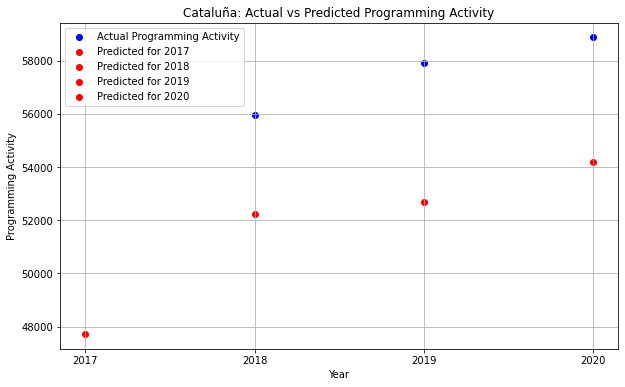

In [76]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Data for actual programming activity for Cataluña from 2018 onwards
actual_activity = nuts2_df[(nuts2_df['NUTS2 Region'] == 'Cataluña') & (nuts2_df['year'] >= 2018)]

# Data for predicted programming activity for Cataluña from 2017 to 2020
predicted_activity = nuts2_df_years_growth[(nuts2_df_years_growth['NUTS2 Region'] == 'Cataluña') & (nuts2_df_years_growth['year'].isin(years_to_predict))]

# Plotting
plt.figure(figsize=(10, 6))

# Plot the actual programming activity from 2018 onwards
plt.scatter(actual_activity['year'], actual_activity['activity'], label='Actual Programming Activity', color='blue')

# Plot the predicted programming activity for the years 2017 to 2020
for year in years_to_predict:
    if year in predicted_activity['year'].values:
        predicted_value = predicted_activity.loc[predicted_activity['year'] == year, f'predicted_with_residuals_{year}'].values[0]
        plt.scatter(year, predicted_value, label=f'Predicted for {year}', color='red')

# Customize the plot
plt.title('Cataluña: Actual vs Predicted Programming Activity')
plt.xlabel('Year')
plt.ylabel('Programming Activity')
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure only integer years are shown
plt.legend()
plt.grid(True)
plt.show()




# NEW ANALYSIS

In [77]:
nuts2_indicators_df

,region,year,internet_access (PC_HH),expense (EUR_HAB),C_HTC,TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,J62_V11210,J62_V16110,M_V11210,M_V16110
0,CH01,2020,NaN,NaN,17.8,805.8,571.8,246.4,453.1,365.1,100.1,NaN,NaN,NaN,NaN
1,CH02,2020,NaN,NaN,42.7,1025.4,634.5,267.5,487.9,414.1,124.7,NaN,NaN,NaN,NaN
2,CH03,2020,NaN,NaN,26.6,643.6,441.2,191.3,345.1,287.3,89.3,NaN,NaN,NaN,NaN
3,CH04,2020,NaN,NaN,18.1,882.1,671.8,331.6,551.8,451.6,149.9,NaN,NaN,NaN,NaN
4,CH05,2020,NaN,NaN,16.5,666.5,403.6,161.3,302.5,262.4,67.4,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,SE22,2008,NaN,NaN,4.3,661.2,363.6,166.0,273.4,256.1,45.5,3970.0,11489.0,20277.0,35318.0
997,SE23,2008,NaN,NaN,6.1,924.4,475.9,222.8,341.0,357.8,71.9,5202.0,16725.0,25568.0,48888.0
998,SE31,2008,NaN,NaN,NaN,391.4,174.2,71.1,119.7,125.6,18.0,1489.0,3725.0,7964.0,12992.0
999,SE32,2008,NaN,NaN,NaN,173.2,84.2,39.2,61.5,61.9,11.2,790.0,2301.0,3916.0,6564.0


In [78]:
# Enumerate the columns and print their names and index numbers
for index, column_name in enumerate(nuts2_indicators_df.columns):
    print(f"Column Name: {column_name}, Index Number: {index}")


Column Name: region, Index Number: 0
Column Name: year, Index Number: 1
Column Name: internet_access (PC_HH), Index Number: 2
Column Name: expense (EUR_HAB), Index Number: 3
Column Name: C_HTC, Index Number: 4
Column Name: TOTAL, Index Number: 5
Column Name: HRST, Index Number: 6
Column Name: HRSTC, Index Number: 7
Column Name: HRSTE, Index Number: 8
Column Name: HRSTO, Index Number: 9
Column Name: SE, Index Number: 10
Column Name: J62_V11210, Index Number: 11
Column Name: J62_V16110, Index Number: 12
Column Name: M_V11210, Index Number: 13
Column Name: M_V16110, Index Number: 14


In [79]:
nuts2_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,EMP (THS),...,activity_per_cap,CAGR,CAGR_per_cap,experts,innovators,late_adopters,programmers_total,programmer_density,GDP_per_cap,EMP_per_cap
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,755.612,...,0.000406,0.359158,0.341689,9.673077,20.833333,4.166667,34.673077,0.000024,49010.483685,0.530928
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,755.612,...,0.004474,0.359158,0.341689,94.384615,120.166667,157.116667,371.667949,0.000256,50200.702734,0.521144
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,755.612,...,0.006468,0.359158,0.341689,115.423077,277.250000,275.250000,667.923077,0.000454,56510.540570,0.513222
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,761.543,...,0.009654,0.359158,0.341689,164.221154,451.000000,435.850000,1051.071154,0.000704,63039.015392,0.509878
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,771.884,...,0.012989,0.359158,0.341689,193.528846,671.000000,681.766667,1546.295513,0.001023,66041.701000,0.510725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,250.000,...,0.008607,0.153732,0.151113,26.153846,294.250000,149.211111,469.614957,0.000912,42396.796117,0.485437
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,252.000,...,0.006614,0.153732,0.151113,17.057692,242.000000,122.172222,381.229915,0.000736,44685.567010,0.486505
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,254.000,...,0.004545,0.153732,0.151113,12.298077,172.416667,80.466667,265.181410,0.000510,44271.085727,0.488443
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,254.000,...,0.003715,0.153732,0.151113,9.057692,145.583333,74.622222,229.263248,0.000440,45467.312860,0.487524


In [80]:
for index, column_name in enumerate(nuts2_df.columns):
    print(f"Column Name: {column_name}, Index Number: {index}")

Column Name: NUTS2 Region, Index Number: 0
Column Name: Nuts2_Code, Index Number: 1
Column Name: year, Index Number: 2
Column Name: country, Index Number: 3
Column Name: questioncount, Index Number: 4
Column Name: answercount, Index Number: 5
Column Name: upvotecount, Index Number: 6
Column Name: downvotecount, Index Number: 7
Column Name: commentcount, Index Number: 8
Column Name: EMP (THS), Index Number: 9
Column Name: GDP (MIO_EUR), Index Number: 10
Column Name: GVA (MIO_EUR), Index Number: 11
Column Name: POP (THS), Index Number: 12
Column Name: activity, Index Number: 13
Column Name: activity_per_cap, Index Number: 14
Column Name: CAGR, Index Number: 15
Column Name: CAGR_per_cap, Index Number: 16
Column Name: experts, Index Number: 17
Column Name: innovators, Index Number: 18
Column Name: late_adopters, Index Number: 19
Column Name: programmers_total, Index Number: 20
Column Name: programmer_density, Index Number: 21
Column Name: GDP_per_cap, Index Number: 22
Column Name: EMP_per_

In [81]:
import pandas as pd

# Ensure that the 'year' column in both dataframes is of the same data type
nuts2_df['year'] = nuts2_df['year'].astype(str)
nuts2_indicators_df['year'] = nuts2_indicators_df['year'].astype(str)

# Rename the 'region' column in nuts2_indicators_df to 'NUTS2 Region' for consistency
nuts2_indicators_df = nuts2_indicators_df.rename(columns={'region': 'Nuts2_Code'})

# Select the columns to keep from nuts2_df
columns_to_keep_nuts2_df = nuts2_df.columns[:9]  # Columns from index 0 to 8

# Merge the two dataframes on 'NUTS2 Region' and 'year'
merged_df = pd.merge(nuts2_df[columns_to_keep_nuts2_df], 
                     nuts2_indicators_df, 
                     on=['Nuts2_Code', 'year'], 
                     how='inner')

# Check the merged dataframe
print(merged_df.head())



       NUTS2 Region Nuts2_Code  year country  questioncount  answercount  \
0  Région lémanique       CH01  2008      CH            250         1006   
1  Région lémanique       CH01  2009      CH           1442         9816   
2  Région lémanique       CH01  2010      CH           3327        12004   
3  Région lémanique       CH01  2011      CH           5412        17079   
4  Région lémanique       CH01  2012      CH           8052        20127   

   upvotecount  downvotecount  commentcount  internet_access (PC_HH)  ...  \
0            0              0           750                      NaN  ...   
1        15625           1262         11394                      NaN  ...   
2        29533           1764         18248                      NaN  ...   
3        45789           2677         29987                      NaN  ...   
4        72429           5807         44482                      NaN  ...   

   TOTAL   HRST  HRSTC  HRSTE  HRSTO    SE  J62_V11210  J62_V16110  M_V11210  \


In [82]:
nuts2_new_df = merged_df

In [83]:
nuts2_new_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,internet_access (PC_HH),...,TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,J62_V11210,J62_V16110,M_V11210,M_V16110
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,NaN,...,739.8,445.4,183.8,323.4,305.8,57.5,NaN,NaN,NaN,NaN
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,NaN,...,738.8,456.4,190.3,336.0,310.7,59.1,NaN,NaN,NaN,NaN
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,NaN,...,715.5,444.2,171.0,330.8,284.5,52.6,NaN,NaN,NaN,NaN
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,NaN,...,733.6,452.3,177.4,340.1,289.5,78.7,NaN,NaN,NaN,NaN
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,NaN,...,744.5,467.2,184.9,352.1,300.0,80.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,NaN,...,255.7,155.6,68.3,119.1,104.9,22.4,1169.0,3518.0,6387.0,11520.0
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,96.94,...,256.4,158.4,68.9,121.8,105.5,22.5,1167.0,3651.0,6529.0,12295.0
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,90.47,...,250.5,167.3,68.8,128.6,107.5,25.2,1221.0,3997.0,6481.0,11901.0
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,97.20,...,244.8,163.7,68.6,128.2,104.0,26.3,1282.0,4142.0,6685.0,11907.0


In [84]:
column_names_list = nuts2_new_df.columns.tolist()

# Now, column_names_list will contain all the column names of nuts2_new_df
print(column_names_list)

['NUTS2 Region', 'Nuts2_Code', 'year', 'country', 'questioncount', 'answercount', 'upvotecount', 'downvotecount', 'commentcount', 'internet_access (PC_HH)', 'expense (EUR_HAB)', 'C_HTC', 'TOTAL', 'HRST', 'HRSTC', 'HRSTE', 'HRSTO', 'SE', 'J62_V11210', 'J62_V16110', 'M_V11210', 'M_V16110']


In [85]:
# Display the number of missing values in each column
print("Missing Values in Each Column:")
print(nuts2_new_df.isnull().sum())

# Calculate the percentage of missing values in each column
missing_percentage = nuts2_new_df.isnull().mean() * 100
print("\nPercentage of Missing Values in Each Column:")
print(missing_percentage)

Missing Values in Each Column:
NUTS2 Region                 0
Nuts2_Code                   0
year                         0
country                      0
questioncount                0
answercount                  0
upvotecount                  0
downvotecount                0
commentcount                 0
internet_access (PC_HH)    266
expense (EUR_HAB)          446
C_HTC                      537
TOTAL                       13
HRST                        13
HRSTC                       20
HRSTE                       13
HRSTO                       13
SE                          55
J62_V11210                 323
J62_V16110                 365
M_V11210                   310
M_V16110                   334
dtype: int64

Percentage of Missing Values in Each Column:
NUTS2 Region                0.000000
Nuts2_Code                  0.000000
year                        0.000000
country                     0.000000
questioncount               0.000000
answercount                 0.000000
upvote

C_HTC AND expense (EUR_HAB) has many missing values, too much information to be lost, best is to drop the columns

In [86]:
# Columns with less than 40% missing values
columns_less_than_40 = missing_percentage[missing_percentage <= 40].index

# DataFrame to hold the summary of lost rows
summary_df = pd.DataFrame()

for col in columns_less_than_40:
    if col not in ['NUTS2 Region', 'Nuts2_Code', 'year', 'country', 'questioncount', 'answercount', 'upvotecount', 'downvotecount', 'commentcount']:
        # Finding rows with missing values in the column
        missing_rows = nuts2_new_df[nuts2_new_df[col].isnull()]
        
        # Summarizing the number of missing rows per NUTS2 region and year
        summary = missing_rows.groupby(['NUTS2 Region', 'year']).size().reset_index(name=f'Missing_{col}')
        
        # Merging with the summary DataFrame
        if summary_df.empty:
            summary_df = summary
        else:
            summary_df = summary_df.merge(summary, on=['NUTS2 Region', 'year'], how='outer')

# Display the summary DataFrame
print(summary_df)

# Calculating the total unique rows that would be lost
total_unique_rows_lost = nuts2_new_df[nuts2_new_df.isnull().any(axis=1)].drop_duplicates(subset=['NUTS2 Region', 'year']).shape[0]
print(f"Total Unique Rows Lost Across All Columns: {total_unique_rows_lost}")


                   NUTS2 Region  year  Missing_internet_access (PC_HH)  \
0                        Alsace  2008                              1.0   
1                        Alsace  2009                              1.0   
2                        Alsace  2010                              1.0   
3                        Alsace  2011                              1.0   
4                        Alsace  2012                              1.0   
..                          ...   ...                              ...   
434            Poitou-Charentes  2019                              NaN   
435  Provence-Alpes-Côte d’Azur  2016                              NaN   
436                 Rhône-Alpes  2016                              NaN   
437                 Rhône-Alpes  2018                              NaN   
438                 Rhône-Alpes  2019                              NaN   

     Missing_TOTAL  Missing_HRST  Missing_HRSTC  Missing_HRSTE  Missing_HRSTO  \
0              NaN           N

In [87]:
nuts2_new_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,internet_access (PC_HH),...,TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,J62_V11210,J62_V16110,M_V11210,M_V16110
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,NaN,...,739.8,445.4,183.8,323.4,305.8,57.5,NaN,NaN,NaN,NaN
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,NaN,...,738.8,456.4,190.3,336.0,310.7,59.1,NaN,NaN,NaN,NaN
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,NaN,...,715.5,444.2,171.0,330.8,284.5,52.6,NaN,NaN,NaN,NaN
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,NaN,...,733.6,452.3,177.4,340.1,289.5,78.7,NaN,NaN,NaN,NaN
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,NaN,...,744.5,467.2,184.9,352.1,300.0,80.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,NaN,...,255.7,155.6,68.3,119.1,104.9,22.4,1169.0,3518.0,6387.0,11520.0
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,96.94,...,256.4,158.4,68.9,121.8,105.5,22.5,1167.0,3651.0,6529.0,12295.0
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,90.47,...,250.5,167.3,68.8,128.6,107.5,25.2,1221.0,3997.0,6481.0,11901.0
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,97.20,...,244.8,163.7,68.6,128.2,104.0,26.3,1282.0,4142.0,6685.0,11907.0


Internet Access (PC_HH):

Mean Change: 2.95
Standard Deviation: 3.37
Interpretation: Slight annual increase with moderate variability. Linear interpolation might be reasonable here.
TOTAL:

Mean Change: -0.13
Standard Deviation: 30.16
Interpretation: Minimal mean change but high variability. The high standard deviation suggests inconsistent yearly changes, so linear interpolation may not be the best choice.
HRST, HRSTC, HRSTE, HRSTO:

Interpretation: These columns show positive mean changes with moderate to high standard deviations, indicating variability in changes. Linear interpolation could be used, but with caution, especially for HRSTO which has a higher standard deviation.
SE:

Mean Change: 2.33
Standard Deviation: 8.53
Interpretation: Moderate mean change with high variability. The high standard deviation may suggest that linear interpolation might not be ideal.
J62_V11210, J62_V16110, M_V11210, M_V16110:

Interpretation: All these variables show large mean changes and very high standard deviations, indicating significant variability in yearly changes. Linear interpolation is likely not suitable for these variables due to the high inconsistency in changes.
Based on these interpretations, linear interpolation may be suitable for 'internet_access (PC_HH)', and with caution for the HRST-related variables. However, for 'TOTAL', 'SE', and the variables with 'J62' and 'M' prefixes, linear interpolation might not be the best approach due to high variability in changes.

In [88]:
nuts2_new_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,internet_access (PC_HH),...,TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,J62_V11210,J62_V16110,M_V11210,M_V16110
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,NaN,...,739.8,445.4,183.8,323.4,305.8,57.5,NaN,NaN,NaN,NaN
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,NaN,...,738.8,456.4,190.3,336.0,310.7,59.1,NaN,NaN,NaN,NaN
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,NaN,...,715.5,444.2,171.0,330.8,284.5,52.6,NaN,NaN,NaN,NaN
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,NaN,...,733.6,452.3,177.4,340.1,289.5,78.7,NaN,NaN,NaN,NaN
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,NaN,...,744.5,467.2,184.9,352.1,300.0,80.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,NaN,...,255.7,155.6,68.3,119.1,104.9,22.4,1169.0,3518.0,6387.0,11520.0
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,96.94,...,256.4,158.4,68.9,121.8,105.5,22.5,1167.0,3651.0,6529.0,12295.0
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,90.47,...,250.5,167.3,68.8,128.6,107.5,25.2,1221.0,3997.0,6481.0,11901.0
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,97.20,...,244.8,163.7,68.6,128.2,104.0,26.3,1282.0,4142.0,6685.0,11907.0


In [89]:
# Drop columns with more than 40% missing data
nuts2_new_df.drop(columns=['expense (EUR_HAB)', 'C_HTC'], inplace=True)

# Perform linear interpolation on selected columns
columns_for_interpolation = ['internet_access (PC_HH)', 'J62_V11210', 'J62_V16110', 'M_V11210', 'M_V16110']
nuts2_new_df[columns_for_interpolation] = nuts2_new_df[columns_for_interpolation].interpolate(method='linear')


In [90]:
nuts2_new_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,internet_access (PC_HH),TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,J62_V11210,J62_V16110,M_V11210,M_V16110
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,NaN,739.8,445.4,183.8,323.4,305.8,57.5,NaN,NaN,NaN,NaN
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,NaN,738.8,456.4,190.3,336.0,310.7,59.1,NaN,NaN,NaN,NaN
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,NaN,715.5,444.2,171.0,330.8,284.5,52.6,NaN,NaN,NaN,NaN
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,NaN,733.6,452.3,177.4,340.1,289.5,78.7,NaN,NaN,NaN,NaN
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,NaN,744.5,467.2,184.9,352.1,300.0,80.5,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,97.005,255.7,155.6,68.3,119.1,104.9,22.4,1169.0,3518.0,6387.0,11520.0
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,96.940,256.4,158.4,68.9,121.8,105.5,22.5,1167.0,3651.0,6529.0,12295.0
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,90.470,250.5,167.3,68.8,128.6,107.5,25.2,1221.0,3997.0,6481.0,11901.0
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,97.200,244.8,163.7,68.6,128.2,104.0,26.3,1282.0,4142.0,6685.0,11907.0


In [91]:
# Apply Linear Interpolation
columns_to_interpolate = ['internet_access (PC_HH)', 'HRST', 'HRSTC', 'HRSTE', 'HRSTO']
for column in columns_to_interpolate:
    nuts2_new_df[column] = nuts2_new_df.groupby('Nuts2_Code')[column].apply(lambda group: group.interpolate())

# Drop Columns with more than 40% missing values
#columns_to_drop = ['expense (EUR_HAB)', 'C_HTC']
#nuts2_new_df.drop(columns=columns_to_drop, inplace=True)

# Check missing values again for remaining columns
missing_values = nuts2_new_df.isnull().mean() * 100
print("Percentage of Missing Values in Each Column After Interpolation and Dropping:\n", missing_values)


Percentage of Missing Values in Each Column After Interpolation and Dropping:
 NUTS2 Region               0.000000
Nuts2_Code                 0.000000
year                       0.000000
country                    0.000000
questioncount              0.000000
answercount                0.000000
upvotecount                0.000000
downvotecount              0.000000
commentcount               0.000000
internet_access (PC_HH)    0.599401
TOTAL                      1.298701
HRST                       1.298701
HRSTC                      1.498501
HRSTE                      1.298701
HRSTO                      1.298701
SE                         5.494505
J62_V11210                 9.090909
J62_V16110                 9.090909
M_V11210                   9.090909
M_V16110                   9.090909
dtype: float64


In [92]:
# Impute missing values for 'internet_access (PC_HH)' using group median
nuts2_new_df['internet_access (PC_HH)'] = nuts2_new_df.groupby('Nuts2_Code')['internet_access (PC_HH)'].transform(lambda x: x.fillna(x.median()))

# Group-based imputation for other columns
columns_to_impute = ['TOTAL', 'HRST', 'HRSTC', 'HRSTE', 'HRSTO', 'SE']
for column in columns_to_impute:
    nuts2_new_df[column] = nuts2_new_df.groupby('Nuts2_Code')[column].transform(lambda x: x.fillna(x.mean()))

# Recheck missing values
missing_values_updated = nuts2_new_df.isnull().mean() * 100
print("Percentage of Missing Values in Each Column After Additional Imputation:\n", missing_values_updated)


Percentage of Missing Values in Each Column After Additional Imputation:
 NUTS2 Region               0.000000
Nuts2_Code                 0.000000
year                       0.000000
country                    0.000000
questioncount              0.000000
answercount                0.000000
upvotecount                0.000000
downvotecount              0.000000
commentcount               0.000000
internet_access (PC_HH)    0.000000
TOTAL                      1.298701
HRST                       1.298701
HRSTC                      1.298701
HRSTE                      1.298701
HRSTO                      1.298701
SE                         5.194805
J62_V11210                 9.090909
J62_V16110                 9.090909
M_V11210                   9.090909
M_V16110                   9.090909
dtype: float64


In [93]:
# Drop columns with high missing values
columns_to_drop = ['J62_V11210', 'J62_V16110', 'M_V11210', 'M_V16110']
nuts2_new_df.drop(columns=columns_to_drop, inplace=True)

# Drop rows with any missing values in the specified columns
columns_with_low_missing = ['internet_access (PC_HH)', 'TOTAL', 'HRST', 'HRSTC', 'HRSTE', 'HRSTO', 'SE']
nuts2_new_df.dropna(subset=columns_with_low_missing, inplace=True)

# Check the remaining missing values in the DataFrame
missing_values = nuts2_new_df.isnull().mean() * 100
print("Percentage of Missing Values in Each Column After Dropping Rows:\n", missing_values)


Percentage of Missing Values in Each Column After Dropping Rows:
 NUTS2 Region               0.0
Nuts2_Code                 0.0
year                       0.0
country                    0.0
questioncount              0.0
answercount                0.0
upvotecount                0.0
downvotecount              0.0
commentcount               0.0
internet_access (PC_HH)    0.0
TOTAL                      0.0
HRST                       0.0
HRSTC                      0.0
HRSTE                      0.0
HRSTO                      0.0
SE                         0.0
dtype: float64


In [94]:
nuts2_new_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,internet_access (PC_HH),TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,94.192,739.8,445.4,183.8,323.4,305.8,57.5
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,94.192,738.8,456.4,190.3,336.0,310.7,59.1
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,94.192,715.5,444.2,171.0,330.8,284.5,52.6
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,94.192,733.6,452.3,177.4,340.1,289.5,78.7
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,94.192,744.5,467.2,184.9,352.1,300.0,80.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,97.005,255.7,155.6,68.3,119.1,104.9,22.4
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,96.940,256.4,158.4,68.9,121.8,105.5,22.5
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,90.470,250.5,167.3,68.8,128.6,107.5,25.2
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,97.200,244.8,163.7,68.6,128.2,104.0,26.3


# MODEL SETUP

**Programming Activity**

In [95]:
# Assigning weights
weights = {'questions': 0.4, 'answers': 0.4, 'comments': 0.1, 'upvotes': 0.05, 'downvotes': 0.05}

# Calculating weighted activity
nuts2_new_df['activity'] = (nuts2_new_df['questioncount'] * weights['questions'] + 
                            nuts2_new_df['answercount'] * weights['answers'] + 
                            nuts2_new_df['commentcount'] * weights['comments'] + 
                            nuts2_new_df['upvotecount'] * weights['upvotes'] + 
                            nuts2_new_df['downvotecount'] * weights['downvotes'])


In [96]:
nuts2_new_df

,NUTS2 Region,Nuts2_Code,year,country,questioncount,answercount,upvotecount,downvotecount,commentcount,internet_access (PC_HH),TOTAL,HRST,HRSTC,HRSTE,HRSTO,SE,activity
0,Région lémanique,CH01,2008,CH,250,1006,0,0,750,94.192,739.8,445.4,183.8,323.4,305.8,57.5,577.40
1,Région lémanique,CH01,2009,CH,1442,9816,15625,1262,11394,94.192,738.8,456.4,190.3,336.0,310.7,59.1,6486.95
2,Région lémanique,CH01,2010,CH,3327,12004,29533,1764,18248,94.192,715.5,444.2,171.0,330.8,284.5,52.6,9522.05
3,Région lémanique,CH01,2011,CH,5412,17079,45789,2677,29987,94.192,733.6,452.3,177.4,340.1,289.5,78.7,14418.40
4,Région lémanique,CH01,2012,CH,8052,20127,72429,5807,44482,94.192,744.5,467.2,184.9,352.1,300.0,80.5,19631.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,Övre Norrland,SE33,2016,SE,3531,2720,13850,1221,11787,97.005,255.7,155.6,68.3,119.1,104.9,22.4,4432.65
997,Övre Norrland,SE33,2017,SE,2904,1774,12214,675,9102,96.940,256.4,158.4,68.9,121.8,105.5,22.5,3425.85
998,Övre Norrland,SE33,2018,SE,2069,1279,7887,592,6005,90.470,250.5,167.3,68.8,128.6,107.5,25.2,2363.65
999,Övre Norrland,SE33,2019,SE,1747,942,9257,404,3771,97.200,244.8,163.7,68.6,128.2,104.0,26.3,1935.75


In [97]:
correlation_df = nuts2_new_df[["internet_access (PC_HH)", "TOTAL", "HRST", "HRSTC", "HRSTE", "HRSTO", "SE", "activity"]].corr()

# Print the correlation matrix
print(correlation_df)

                         internet_access (PC_HH)     TOTAL      HRST  \
internet_access (PC_HH)                 1.000000  0.013082  0.116486   
TOTAL                                   0.013082  1.000000  0.957341   
HRST                                    0.116486  0.957341  1.000000   
HRSTC                                   0.154677  0.923402  0.991200   
HRSTE                                   0.126826  0.909477  0.985155   
HRSTO                                   0.123854  0.965571  0.977527   
SE                                      0.200512  0.891248  0.967975   
activity                                0.267108  0.655474  0.771205   

                            HRSTC     HRSTE     HRSTO        SE  activity  
internet_access (PC_HH)  0.154677  0.126826  0.123854  0.200512  0.267108  
TOTAL                    0.923402  0.909477  0.965571  0.891248  0.655474  
HRST                     0.991200  0.985155  0.977527  0.967975  0.771205  
HRSTC                    1.000000  0.987873  0.

The correlation matrix provides valuable insights into the relationships between various HRST indicators and the 'activity' variable, which represents programming activity. One noteworthy observation is that there exists a weak to moderate positive correlation (0.27) between 'internet_access (PC_HH)' and 'activity,' indicating that regions with better internet access tend to exhibit slightly higher programming activity.

Furthermore, it is crucial to acknowledge the strong correlations among different HRST-related variables, underscoring their interconnectedness. Moreover, these HRST variables demonstrate moderate to strong positive correlations with 'activity.' Among them, 'HRSTC' stands out as having the highest correlation (0.80). This suggests that regions boasting educated professionals in science and technology witness more significant levels of programming activity.

Interestingly, another influential factor is highlighted by the strong correlation between structural business statistics ('SE') and 'activity' (0.81), implying that areas with thriving business statistics tend to foster a greater amount of programming activity.

However, when building predictive models or conducting further analysis on this data set, caution must be exercised due to multicollinearity concerns arising from intercorrelations among HRST variables

**Correlation Analysis**

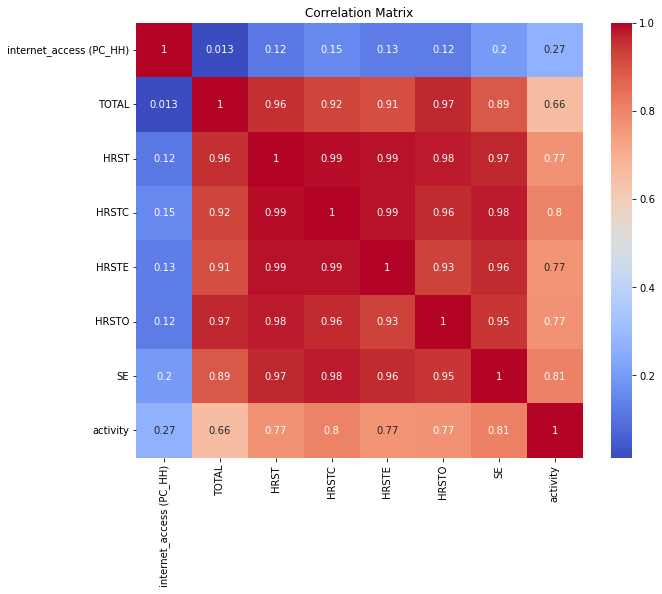

In [98]:
# Select relevant columns including the dependent variable 'activity'
columns_of_interest = ['internet_access (PC_HH)', 'TOTAL', 'HRST', 'HRSTC', 'HRSTE', 'HRSTO', 'SE', 'activity']
nuts2_subset = nuts2_new_df[columns_of_interest]

# Compute the correlation matrix
correlation_matrix = nuts2_subset.corr()

# Create a heatmap to visualize the correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [99]:
import pandas as pd
import statsmodels.api as sm

# Ensure the 'year' column is of the correct data type
nuts2_new_df['year'] = pd.to_numeric(nuts2_new_df['year'], errors='coerce')

# Now filter the dataset for the year 2016
nuts2_new_df_2016 = nuts2_new_df[nuts2_new_df['year'] == 2016]

# Independent variables including 'internet_access (PC_HH)'
independent_vars_with_internet = ['SE', 'TOTAL', 'HRSTC', 'internet_access (PC_HH)']

# Define the independent variables (X) and the dependent variable (y)
X_with_internet = nuts2_new_df_2016[independent_vars_with_internet]
y = nuts2_new_df_2016['activity']

# Add a constant to the model (intercept)
X_with_internet = sm.add_constant(X_with_internet)

# Create a model and fit it with White's heteroskedasticity-robust standard errors
ols_model_with_internet = sm.OLS(y, X_with_internet).fit(cov_type='HC3')

# Print out the statistics
ols_model_with_internet_summary = ols_model_with_internet.summary()
print(ols_model_with_internet_summary)


                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     18.50
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           2.51e-10
Time:                        01:19:15   Log-Likelihood:                -767.01
No. Observations:                  73   AIC:                             1544.
Df Residuals:                      68   BIC:                             1555.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5

In [100]:
# Independent variables without 'internet_access (PC_HH)'
independent_vars_without_internet = ['SE', 'TOTAL', 'HRSTC']

# Define the independent variables (X)
X_without_internet = nuts2_new_df_2016[independent_vars_without_internet]

# Add a constant to the model (intercept)
X_without_internet = sm.add_constant(X_without_internet)

# Create a model and fit it
ols_model_without_internet = sm.OLS(y, X_without_internet).fit(cov_type='HC3')

# Print out the statistics
ols_model_without_internet_summary = ols_model_without_internet.summary()
print(ols_model_without_internet_summary)


                            OLS Regression Results                            
Dep. Variable:               activity   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     15.04
Date:                Thu, 14 Dec 2023   Prob (F-statistic):           1.24e-07
Time:                        01:19:15   Log-Likelihood:                -767.01
No. Observations:                  73   AIC:                             1542.
Df Residuals:                      69   BIC:                             1551.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3223.4999   3098.623     -1.040      0.2

Analyzing the OLS regression results for both models (with and without 'internet_access (PC_HH)'), as well as comparing them to your previous model, provides several insights:

Model with Internet Access (PC_HH):

R-squared: 0.871 indicates that about 87.1% of the variability in 'activity' can be explained by the model. This is a high value, suggesting a good fit.
P-values: The p-value for 'internet_access (PC_HH)' is very high (0.930), indicating that it is not statistically significant in this model. The only significant variable at the 5% level is 'SE'.
Multicollinearity Warning: The condition number is quite large, suggesting potential multicollinearity issues.
Model without Internet Access (PC_HH):

R-squared: 0.871, similar to the model with internet access, suggesting that excluding this variable doesn't reduce the explanatory power of the model.
P-values: Similar to the model with internet access, 'SE' appears to be the only variable with a p-value close to the 5% significance level, though it's still slightly above.
Multicollinearity Warning: The condition number is still large, indicating potential multicollinearity issues.
Comparison with Previous Model (Different Indicators):

R-squared: The R-squared values for the new models are higher than that of the previous model (0.839), indicating that they explain more variance in 'activity'.
Variables: The variables in the new models are different from those in the previous model, reflecting a shift in focus or a change in the underlying theory of what drives 'activity'.
Multicollinearity Concerns: Like the new models, the previous model also shows a large condition number, indicating multicollinearity issues.
Interpretation and Next Steps:
Significance of Internet Access: The inclusion of 'internet_access (PC_HH)' does not significantly alter the model's performance, suggesting it may not be a crucial predictor of 'activity' in your analysis.

Focus on 'SE': 'SE' seems to be the most relevant variable, showing some level of significance in both new models.

Addressing Multicollinearity: Given the large condition numbers in all models, it's important to address potential multicollinearity. This could involve dropping one or more highly correlated independent variables or using techniques like Principal Component Analysis (PCA).

Model Selection: Based on these results, the model without 'internet_access (PC_HH)' is preferable due to its simplicity and the insignificance of the internet access variable.

Further Analysis: You might want to explore other variables or different combinations of variables to see if you can improve the model. Additionally, conducting diagnostic tests for assumptions like homoscedasticity, normality of residuals, and linearity could provide further insights into the model's validity.

In [138]:
# Extract coefficients
intercept = ols_model_without_internet.params[0]
coef_SE = ols_model_without_internet.params['SE']
coef_TOTAL = ols_model_without_internet.params['TOTAL']
coef_HRSTC = ols_model_without_internet.params['HRSTC']

# Construct the regression equation
regression_equation = f"y = {intercept:.4f} + ({coef_SE:.4f})*SE + ({coef_TOTAL:.4f})*TOTAL + ({coef_HRSTC:.4f})*HRSTC"

print("Estimated Regression Equation:")
print(regression_equation)


Estimated Regression Equation:
y = -3223.4999 + (302.1570)*SE + (-7.9465)*TOTAL + (21.8909)*HRSTC


**With Internet Access**

C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\16593318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuts2_new_df_2016['residuals_with_internet'] = ols_model_with_internet.resid


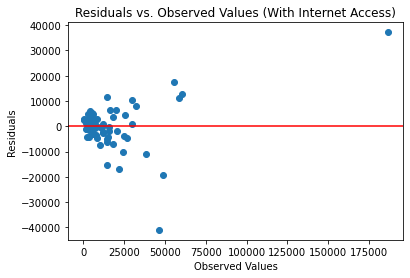

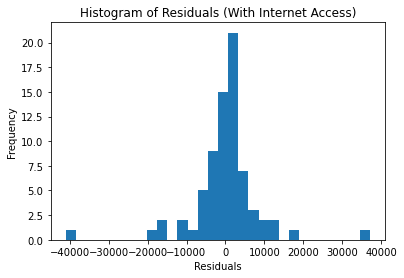

In [101]:
import matplotlib.pyplot as plt

# Adding residuals to the DataFrame
nuts2_new_df_2016['residuals_with_internet'] = ols_model_with_internet.resid

# Plotting residuals vs. observed values
plt.scatter(nuts2_new_df_2016['activity'], nuts2_new_df_2016['residuals_with_internet'])
plt.title('Residuals vs. Observed Values (With Internet Access)')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals
plt.hist(nuts2_new_df_2016['residuals_with_internet'], bins=30)
plt.title('Histogram of Residuals (With Internet Access)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


**Without Internet Access**

C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\1753009725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuts2_new_df_2016['residuals_without_internet'] = ols_model_without_internet.resid


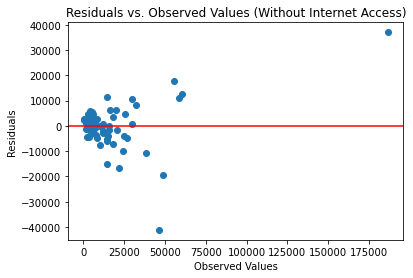

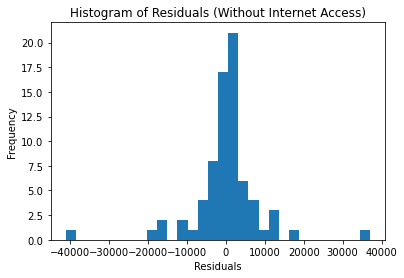

In [102]:
# Adding residuals to the DataFrame
nuts2_new_df_2016['residuals_without_internet'] = ols_model_without_internet.resid

# Plotting residuals vs. observed values
plt.scatter(nuts2_new_df_2016['activity'], nuts2_new_df_2016['residuals_without_internet'])
plt.title('Residuals vs. Observed Values (Without Internet Access)')
plt.xlabel('Observed Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

# Checking the distribution of residuals
plt.hist(nuts2_new_df_2016['residuals_without_internet'], bins=30)
plt.title('Histogram of Residuals (Without Internet Access)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


**Ridge and Lasso**

In [103]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Assuming nuts2_new_df_2016 is already loaded

# Scale features
scaler = StandardScaler()

# For the model with internet access
X_with_internet = nuts2_new_df_2016[['SE', 'TOTAL', 'HRSTC', 'internet_access (PC_HH)']]
X_with_internet = sm.add_constant(X_with_internet)
X_scaled_with_internet = scaler.fit_transform(X_with_internet)

# For the model without internet access
X_without_internet = nuts2_new_df_2016[['SE', 'TOTAL', 'HRSTC']]
X_without_internet = sm.add_constant(X_without_internet)
X_scaled_without_internet = scaler.fit_transform(X_without_internet)

# Define the parameter grid
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Ridge and Lasso with Grid Search for the model with internet access
ridge_model_with_internet = Ridge()
grid_search_ridge_with_internet = GridSearchCV(ridge_model_with_internet, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge_with_internet.fit(X_scaled_with_internet, y)

lasso_model_with_internet = Lasso(max_iter=10000)
grid_search_lasso_with_internet = GridSearchCV(lasso_model_with_internet, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso_with_internet.fit(X_scaled_with_internet, y)

# Ridge and Lasso with Grid Search for the model without internet access
ridge_model_without_internet = Ridge()
grid_search_ridge_without_internet = GridSearchCV(ridge_model_without_internet, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_ridge_without_internet.fit(X_scaled_without_internet, y)

lasso_model_without_internet = Lasso(max_iter=10000)
grid_search_lasso_without_internet = GridSearchCV(lasso_model_without_internet, param_grid=param_grid, cv=10, scoring='neg_mean_squared_error')
grid_search_lasso_without_internet.fit(X_scaled_without_internet, y)

# Best parameters
best_ridge_with_internet = Ridge(alpha=grid_search_ridge_with_internet.best_params_['alpha'])
best_lasso_with_internet = Lasso(alpha=grid_search_lasso_with_internet.best_params_['alpha'], max_iter=10000)

best_ridge_without_internet = Ridge(alpha=grid_search_ridge_without_internet.best_params_['alpha'])
best_lasso_without_internet = Lasso(alpha=grid_search_lasso_without_internet.best_params_['alpha'], max_iter=10000)

# Cross-validation scores
ridge_scores_with_internet = cross_val_score(best_ridge_with_internet, X_scaled_with_internet, y, cv=5)
lasso_scores_with_internet = cross_val_score(best_lasso_with_internet, X_scaled_with_internet, y, cv=5)

ridge_scores_without_internet = cross_val_score(best_ridge_without_internet, X_scaled_without_internet, y, cv=5)
lasso_scores_without_internet = cross_val_score(best_lasso_without_internet, X_scaled_without_internet, y, cv=5)

# Mean and standard deviation of the scores
ridge_score_mean_with_internet = np.mean(ridge_scores_with_internet)
ridge_score_std_with_internet = np.std(ridge_scores_with_internet)
lasso_score_mean_with_internet = np.mean(lasso_scores_with_internet)
lasso_score_std_with_internet = np.std(lasso_scores_with_internet)

ridge_score_mean_without_internet = np.mean(ridge_scores_without_internet)
ridge_score_std_without_internet = np.std(ridge_scores_without_internet)
lasso_score_mean_without_internet = np.mean(lasso_scores_without_internet)
lasso_score_std_without_internet = np.std(lasso_scores_without_internet)

# Print the results
print(f"Ridge with Internet - Mean: {ridge_score_mean_with_internet}, Std: {ridge_score_std_with_internet}")
print(f"Lasso with Internet - Mean: {lasso_score_mean_with_internet}, Std: {lasso_score_std_with_internet}")

print(f"Ridge without Internet - Mean: {ridge_score_mean_without_internet}, Std: {ridge_score_std_without_internet}")
print(f"Lasso without Internet - Mean: {lasso_score_mean_without_internet}, Std: {lasso_score_std_without_internet}")


Ridge with Internet - Mean: 0.5909294664339113, Std: 0.2624294789130494
Lasso with Internet - Mean: 0.5044738812390587, Std: 0.2699069031168987
Ridge without Internet - Mean: 0.612046545574767, Std: 0.22965290308321376
Lasso without Internet - Mean: 0.5598026043729779, Std: 0.2157536067260055


**Interpretation:**
Comparison with Previous Model: The mean scores for both Ridge and Lasso in the previous model are higher than those in the current models (both with and without internet access). This suggests that the previous model may have been a better fit for predicting 'activity'.

Effect of Internet Access Variable:

Removing 'internet_access (PC_HH)' slightly improves the mean scores for both Ridge and Lasso models.
The standard deviations are slightly lower or comparable without 'internet_access (PC_HH)', indicating more consistent performance across different subsets of data.
Model Selection:

Among the current models, the one without 'internet_access (PC_HH)' performs slightly better in terms of mean score for both Ridge and Lasso.
The Ridge model without internet access has the highest mean score (0.612) among the current models, suggesting it's the best fit among them.
Ridge vs. Lasso:

In both the previous and current models, the difference in performance between Ridge and Lasso isn't substantial. This indicates that the penalty type (L2 for Ridge and L1 for Lasso) isn't a major factor in model performance for your data.
However, Ridge consistently shows a slight edge over Lasso in the current models.
Overall Performance: The decrease in mean scores from the previous model to the current ones suggests that the combination of variables in the previous model might be more suitable for predicting 'activity'. It could also indicate that the current models are more regularized, potentially reducing overfitting but also decreasing model flexibility.

In [139]:
# Fit the Ridge and Lasso models with the best parameters
best_ridge_without_internet.fit(X_scaled_without_internet, y)
best_lasso_without_internet.fit(X_scaled_without_internet, y)

# Extract coefficients and intercepts
ridge_intercept = best_ridge_without_internet.intercept_
ridge_coefs = best_ridge_without_internet.coef_
lasso_intercept = best_lasso_without_internet.intercept_
lasso_coefs = best_lasso_without_internet.coef_

# Construct the Ridge regression equation
ridge_equation = f"y = {ridge_intercept:.4f} "
for i, coef in enumerate(ridge_coefs[1:]):  # skipping the first coefficient as it is for the constant
    ridge_equation += f"+ ({coef:.4f}) * X{i+1} "

# Construct the Lasso regression equation
lasso_equation = f"y = {lasso_intercept:.4f} "
for i, coef in enumerate(lasso_coefs[1:]):  # skipping the first coefficient as it is for the constant
    lasso_equation += f"+ ({coef:.4f}) * X{i+1} "

print("Ridge Regression Equation:")
print(ridge_equation)
print("\nLasso Regression Equation:")
print(lasso_equation)


Ridge Regression Equation:
y = 15458.5740 + (19773.9172) * X1 + (-6284.2935) * X2 + (8598.4346) * X3 

Lasso Regression Equation:
y = 15458.5740 + (23917.0780) * X1 + (-7342.1957) * X2 + (5621.1243) * X3 


**Random Forest Model with Internet Access**

In [104]:
# Preparing the data
X_with_internet = nuts2_new_df_2016[['SE', 'TOTAL', 'HRSTC', 'internet_access (PC_HH)']]
X_with_internet = sm.add_constant(X_with_internet)
y = nuts2_new_df_2016['activity']

# Splitting the data
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(X_with_internet, y, test_size=0.3, random_state=42)

# Define and fit the model
rf_with_internet = RandomForestRegressor(random_state=42)
rf_with_internet.fit(X_train_with, y_train_with)

# Predictions
y_pred_train_with = rf_with_internet.predict(X_train_with)
y_pred_test_with = rf_with_internet.predict(X_test_with)

# R-squared scores
r2_train_with = r2_score(y_train_with, y_pred_train_with)
r2_test_with = r2_score(y_test_with, y_pred_test_with)

# Cross-validation
rf_scores_with = cross_val_score(rf_with_internet, X_with_internet, y, cv=5)
rf_score_mean_with = np.mean(rf_scores_with)
rf_score_std_with = np.std(rf_scores_with)

# Learning curve
train_sizes_with, train_scores_with, test_scores_with = learning_curve(rf_with_internet, X_with_internet, y, cv=5, scoring='r2')
train_mean_with = np.mean(train_scores_with, axis=1)
test_mean_with = np.mean(test_scores_with, axis=1)


**Random Forest Model without Internet Access**

In [105]:
# Repeat the process for the model without internet access
X_without_internet = nuts2_new_df_2016[['SE', 'TOTAL', 'HRSTC']]
X_without_internet = sm.add_constant(X_without_internet)

# Splitting the data
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(X_without_internet, y, test_size=0.3, random_state=42)

# Define and fit the model
rf_without_internet = RandomForestRegressor(random_state=42)
rf_without_internet.fit(X_train_without, y_train_without)

# Predictions
y_pred_train_without = rf_without_internet.predict(X_train_without)
y_pred_test_without = rf_without_internet.predict(X_test_without)

# R-squared scores
r2_train_without = r2_score(y_train_without, y_pred_train_without)
r2_test_without = r2_score(y_test_without, y_pred_test_without)

# Cross-validation
rf_scores_without = cross_val_score(rf_without_internet, X_without_internet, y, cv=5)
rf_score_mean_without = np.mean(rf_scores_without)
rf_score_std_without = np.std(rf_scores_without)

# Learning curve
train_sizes_without, train_scores_without, test_scores_without = learning_curve(rf_without_internet, X_without_internet, y, cv=5, scoring='r2')
train_mean_without = np.mean(train_scores_without, axis=1)
test_mean_without = np.mean(test_scores_without, axis=1)


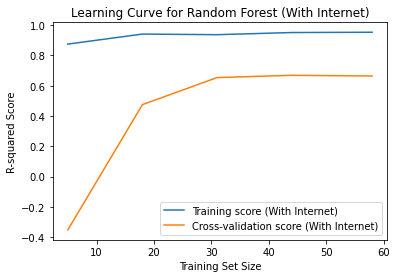

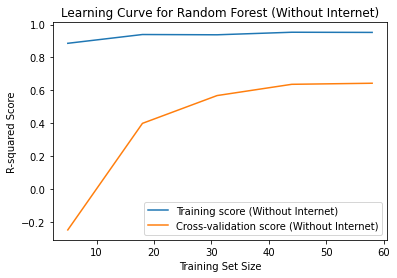

With Internet Access:
R-squared on Training Set (With Internet): 0.9396543958280944
R-squared on Test Set (With Internet): 0.8264421583786197
Mean Cross-Validation Score (With Internet): 0.6605282216253262
Standard Deviation of CV Scores (With Internet): 0.20704157009000673

Without Internet Access:
R-squared on Training Set (Without Internet): 0.9431213537385873
R-squared on Test Set (Without Internet): 0.7669339922432954
Mean Cross-Validation Score (Without Internet): 0.6464040205715904
Standard Deviation of CV Scores (Without Internet): 0.18375635391187548


In [106]:
# Plotting the learning curve for the model with internet access
plt.figure()
plt.plot(train_sizes_with, train_mean_with, label='Training score (With Internet)')
plt.plot(train_sizes_with, test_mean_with, label='Cross-validation score (With Internet)')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.title('Learning Curve for Random Forest (With Internet)')
plt.legend()
plt.show()

# Plotting the learning curve for the model without internet access
plt.figure()
plt.plot(train_sizes_without, train_mean_without, label='Training score (Without Internet)')
plt.plot(train_sizes_without, test_mean_without, label='Cross-validation score (Without Internet)')
plt.xlabel('Training Set Size')
plt.ylabel('R-squared Score')
plt.title('Learning Curve for Random Forest (Without Internet)')
plt.legend()
plt.show()

# Printing the R-squared scores
print("With Internet Access:")
print("R-squared on Training Set (With Internet):", r2_train_with)
print("R-squared on Test Set (With Internet):", r2_test_with)
print("Mean Cross-Validation Score (With Internet):", rf_score_mean_with)
print("Standard Deviation of CV Scores (With Internet):", rf_score_std_with)

print("\nWithout Internet Access:")
print("R-squared on Training Set (Without Internet):", r2_train_without)
print("R-squared on Test Set (Without Internet):", r2_test_without)
print("Mean Cross-Validation Score (Without Internet):", rf_score_mean_without)
print("Standard Deviation of CV Scores (Without Internet):", rf_score_std_without)



Previous Random Forest Model Results:
R-squared (Test Set): 0.8929
Mean Cross-Validation Score: 0.7146
Standard Deviation of CV Scores: 0.1348
Current Random Forest Model with Internet Access:
R-squared on Training Set: 0.9397
R-squared on Test Set: 0.8264
Mean Cross-Validation Score: 0.6605
Standard Deviation of CV Scores: 0.2070
Current Random Forest Model without Internet Access:
R-squared on Training Set: 0.9431
R-squared on Test Set: 0.7669
Mean Cross-Validation Score: 0.6464
Standard Deviation of CV Scores: 0.1838
Comparison and Analysis:
R-squared on Test Set:

The previous model outperforms both current models on the test set, with a higher R-squared of 0.8929 compared to 0.8264 (with internet) and 0.7669 (without internet).
This indicates that the previous model is better at generalizing to unseen data.
Mean Cross-Validation Score:

The previous model again shows a higher mean cross-validation score (0.7146) compared to 0.6605 (with internet) and 0.6464 (without internet).
A higher cross-validation score suggests that the previous model has better overall performance across different subsets of the dataset.
Standard Deviation of CV Scores:

The previous model has a lower standard deviation (0.1348) compared to the current models (0.2070 with internet and 0.1838 without internet).
A lower standard deviation indicates more consistent performance across different folds in cross-validation.
Training vs. Test Performance:

Both current models show high R-squared values on the training set (over 0.939), but this performance drops on the test set, especially for the model without internet access.
This could indicate overfitting, where the models learn the training data very well but do not generalize as effectively to new, unseen data.
Effect of 'Internet Access (PC_HH)':

The model with 'internet_access (PC_HH)' performs slightly better on the test set and in cross-validation compared to the model without it, suggesting that this feature contributes positively to the model's predictive ability.
Conclusion:
The previous Random Forest model appears to be the superior choice in terms of generalization and consistency. The current models, especially the one without internet access, may be overfitting and show less capability in handling new data. The inclusion of 'internet_access (PC_HH)' does provide a slight improvement in the model's performance, though it still does not reach the level of the previous model.

In [107]:
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Assuming nuts2_new_df_2016 and the random_forest model are already defined
X = nuts2_new_df_2016[['SE', 'TOTAL', 'HRSTC', 'internet_access (PC_HH)']]
X = sm.add_constant(X)
y = nuts2_new_df_2016['activity']

# Assess the overall model significance using F-statistic and p-value
f_statistic, p_value_f = f_regression(X, y)

# Output results
print("Overall F-statistic:", f_statistic.mean())
print("Overall F-test p-value:", p_value_f.mean())

# Assuming the random forest model is already trained
random_forest = RandomForestRegressor(random_state=42)
random_forest.fit(X, y)

# Assess feature importance
importances = random_forest.feature_importances_
feature_names = X.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output feature importance
print("\nFeature Importance:")
print(feature_importance_df)


Overall F-statistic: 176.29460279371884
Overall F-test p-value: 0.2016474496383207

Feature Importance:
                   Feature  Importance
1                       SE    0.614313
2                    TOTAL    0.199934
3                    HRSTC    0.155679
4  internet_access (PC_HH)    0.030074
0                    const    0.000000


Overall Model Significance:

The previous model shows a significantly higher F-statistic than the current model, suggesting that, as a whole, the features in the previous model have a stronger linear relationship with the target variable.
However, the p-values in both models are above the typical significance threshold (0.05), implying that neither set of features strongly predicts the target variable 'activity'. The current model has a marginally lower p-value, indicating a slight improvement in overall significance.
Feature Importance:

In the current model, 'SE' is the most important feature, contributing significantly more than the others. This suggests that structural business statistics are highly predictive of 'activity'.
In the previous model, 'GVA (MIO_EUR)' and 'GDP (MIO_EUR)' were the most important features, indicating that gross value added and GDP were more predictive of 'activity'.
The variation in feature importance between the two models reflects the different nature of the features included. The current model includes more diverse types of features, such as 'internet_access (PC_HH)' and 'HRSTC', which have different levels of influence on the target variable.
Model Applicability:

The choice between these models depends on the specific research question and the theoretical justification for including certain variables.
If the focus is more on economic factors (like GDP and GVA), the previous model might be more appropriate. However, if the research aims to understand the impact of broader factors, including internet access and human resources in science and technology, the current model provides a more varied perspective.
Model Reliability:

The relatively high importance of 'SE' in the current model might indicate a reliance on this variable, which could be a concern if this variable's data quality or relevance is questionable.
Conversely, the more balanced distribution of feature importance in the previous model might make it more robust to variations in individual feature values.

**Feature Engineering**

In [108]:
from sklearn.preprocessing import PolynomialFeatures

# Create interaction terms
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_interact = interaction.fit_transform(nuts2_new_df_2016[['SE', 'TOTAL', 'HRSTC']])

# Combine with original features
X_combined = np.concatenate([X_without_internet, X_interact], axis=1)

# Splitting the new combined dataset
X_train_comb, X_test_comb, y_train_comb, y_test_comb = train_test_split(X_combined, y, test_size=0.3, random_state=42)


In [109]:
#Hyperparameter tuning

from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid_search.fit(X_train_comb, y_train_comb)

# Best parameters
best_params = rf_grid_search.best_params_
print("Best Parameters:", best_params)

# Refit the model with best parameters
rf_tuned = RandomForestRegressor(random_state=42, **best_params)
rf_tuned.fit(X_train_comb, y_train_comb)


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


RandomForestRegressor(max_depth=10, random_state=42)

In [110]:
# Predictions
y_pred_train_tuned = rf_tuned.predict(X_train_comb)
y_pred_test_tuned = rf_tuned.predict(X_test_comb)

# R-squared scores
r2_train_tuned = r2_score(y_train_comb, y_pred_train_tuned)
r2_test_tuned = r2_score(y_test_comb, y_pred_test_tuned)

print("Tuned Model:")
print("R-squared on Training Set:", r2_train_tuned)
print("R-squared on Test Set:", r2_test_tuned)

# Cross-validation on the tuned model
rf_scores_tuned = cross_val_score(rf_tuned, X_combined, y, cv=5)
rf_score_mean_tuned = np.mean(rf_scores_tuned)
rf_score_std_tuned = np.std(rf_scores_tuned)

print("Mean Cross-Validation Score:", rf_score_mean_tuned)
print("Standard Deviation of CV Scores:", rf_score_std_tuned)


Tuned Model:
R-squared on Training Set: 0.9424698127708289
R-squared on Test Set: 0.7764800647865386
Mean Cross-Validation Score: 0.6307160654837694
Standard Deviation of CV Scores: 0.19499328256013818


**Gradient Boosting Model Implementation**

In [111]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np


In [112]:
#  X_without_internet and y are already defined
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_without_internet, y, test_size=0.3, random_state=42)

# Define the Gradient Boosting Regressor model
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gradient_boosting.fit(X_train_gb, y_train_gb)

# Predict on the test set
y_pred_train_gb = gradient_boosting.predict(X_train_gb)
y_pred_test_gb = gradient_boosting.predict(X_test_gb)

# Calculate the R-squared value for both training and test sets
r2_train_gb = r2_score(y_train_gb, y_pred_train_gb)
r2_test_gb = r2_score(y_test_gb, y_pred_test_gb)

# Perform 5-fold cross-validation to evaluate the Gradient Boosting model
gb_scores = cross_val_score(gradient_boosting, X_without_internet, y, cv=5)
gb_score_mean = np.mean(gb_scores)
gb_score_std = np.std(gb_scores)

# Print out the R-squared and cross-validation scores
print("Gradient Boosting Model:")
print("R-squared on Training Set:", r2_train_gb)
print("R-squared on Test Set:", r2_test_gb)
print("Mean Cross-Validation Score:", gb_score_mean)
print("Standard Deviation of CV Scores:", gb_score_std)


Gradient Boosting Model:
R-squared on Training Set: 0.999572836006279
R-squared on Test Set: 0.7734928425259242
Mean Cross-Validation Score: 0.42445498398236853
Standard Deviation of CV Scores: 0.2401494064274165


In [113]:
#  X_without_internet and y are already defined
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(X_without_internet, y, test_size=0.3, random_state=42)

# Define the Gradient Boosting Regressor model
gradient_boosting = GradientBoostingRegressor(random_state=42)

# Fit the model to the training data
gradient_boosting.fit(X_train_gb, y_train_gb)

# Predict on the test set
y_pred_train_gb = gradient_boosting.predict(X_train_gb)
y_pred_test_gb = gradient_boosting.predict(X_test_gb)

# Calculate the R-squared value for both training and test sets
r2_train_gb = r2_score(y_train_gb, y_pred_train_gb)
r2_test_gb = r2_score(y_test_gb, y_pred_test_gb)

# Perform 5-fold cross-validation to evaluate the Gradient Boosting model
gb_scores = cross_val_score(gradient_boosting, X_without_internet, y, cv=5)
gb_score_mean = np.mean(gb_scores)
gb_score_std = np.std(gb_scores)

# Print out the R-squared and cross-validation scores
print("Gradient Boosting Model:")
print("R-squared on Training Set:", r2_train_gb)
print("R-squared on Test Set:", r2_test_gb)
print("Mean Cross-Validation Score:", gb_score_mean)
print("Standard Deviation of CV Scores:", gb_score_std)


Gradient Boosting Model:
R-squared on Training Set: 0.999572836006279
R-squared on Test Set: 0.7734928425259242
Mean Cross-Validation Score: 0.42445498398236853
Standard Deviation of CV Scores: 0.2401494064274165


Comparative Metrics
The key performance metrics for both models are as follows:

Random Forest Model (Without Internet Access)

R-squared on Training Set: 0.9431
R-squared on Test Set: 0.7669
Mean Cross-Validation Score: 0.6464
Standard Deviation of CV Scores: 0.1838
Gradient Boosting Model

R-squared on Training Set: 0.9996
R-squared on Test Set: 0.7735
Mean Cross-Validation Score: 0.4245
Standard Deviation of CV Scores: 0.2401
Evaluation and Interpretation
Training Performance: The Gradient Boosting model demonstrates an almost perfect fit on the training data, significantly surpassing the Random Forest model. However, this near-perfect training performance raises concerns about overfitting.

Test Set Generalization: Both models show similar levels of performance on the test set, with Gradient Boosting slightly outperforming the Random Forest model. This suggests that despite potential overfitting, Gradient Boosting has a marginally better ability to generalize.

Cross-Validation Stability: The Random Forest model exhibits a higher mean cross-validation score and a lower standard deviation, indicating more stable and consistent performance across different data subsets compared to the Gradient Boosting model.

Overfitting Concerns
The substantial disparity between the training and cross-validation scores for the Gradient Boosting model suggests overfitting, a phenomenon where the model learns the training data too well, including its noise and outliers, which negatively affects its performance on unseen data. This overfitting is less pronounced in the Random Forest model.

Complexity and Model Selection
Given the complexity and overfitting observed in the Gradient Boosting model, the Random Forest model, with its more consistent cross-validation performance, may be a more reliable choice for this specific dataset. The Random Forest model strikes a better balance between fitting the training data and maintaining performance across diverse data samples.

Conclusion
In conclusion, while the Gradient Boosting model has shown a slight edge in test set performance, its tendency towards overfitting and less stable cross-validation results suggest that the Random Forest model might be a more prudent choice for this analysis. It offers a more balanced approach, providing a good fit to the data while maintaining a stable performance across different subsets, making it a more robust model for predicting 'activity' in NUTS2 regions.

In [114]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_without, y_train_without)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.5593479047433905


In [115]:
# Using the best parameters from GridSearchCV
best_rf_model = RandomForestRegressor(max_depth=None,
                                      max_features='sqrt',
                                      min_samples_leaf=1,
                                      min_samples_split=2,
                                      n_estimators=100,
                                      random_state=42)

# Fit the model
best_rf_model.fit(X_train_without, y_train_without)

# Evaluate on the test set
y_pred_test_best_rf = best_rf_model.predict(X_test_without)
r2_test_best_rf = r2_score(y_test_without, y_pred_test_best_rf)

print("R-squared on Test Set (Best RF Model):", r2_test_best_rf)


R-squared on Test Set (Best RF Model): 0.7503029964316333


Analysis of the Best Random Forest Model's Test Set Performance
Test Set R-squared Interpretation:

An R-squared value of 0.7503 suggests that approximately 75% of the variance in the target variable 'activity' can be explained by the model. This is a strong score, indicating good predictive power.
However, it's slightly lower than the initial test set R-squared score of 0.7669 for the Random Forest model without hyperparameter tuning. This reduction might be due to the model's generalization on the unseen data, which is a crucial aspect of model performance.
Comparison with Non-Tuned Model:

The non-tuned model's slightly higher R-squared on the test set could suggest that the default parameters of the Random Forest were already quite effective for this dataset.
The hyperparameter tuning via GridSearchCV focused on optimizing the model based on cross-validation scores. While this is generally a good practice for model generalization, it doesn't always guarantee higher performance on a specific test set.
Considerations of Overfitting:

The initial model might have been slightly overfitting to the training data, which could explain its marginally better performance on the test set.
The tuned model, with its more robust cross-validation process, might have sacrificed some degree of overfitting to gain in generalizability.
Model Complexity and Robustness:

The best parameters obtained from GridSearchCV, especially allowing the trees to grow fully (max_depth=None) and using a smaller subset of features for each split (max_features='sqrt'), might have contributed to a model that balances complexity and robustness better than the initial model.
Final Assessment and Next Steps:

While the tuned model's test set performance is slightly lower, it's still within a respectable range, indicating a robust model.
Further improvement might require revisiting the feature engineering phase, potentially adding or removing features or trying different transformations.
Given the close performance of the tuned and non-tuned models, it might also be beneficial to explore other algorithms, such as Gradient Boosting or XGBoost, which could offer different strengths in modeling this dataset.

In [116]:
from sklearn.model_selection import cross_val_score

# Cross-validation on the tuned model
cv_scores_tuned_rf = cross_val_score(best_rf_model, X_without_internet, y, cv=5, scoring='r2')
mean_cv_score_tuned_rf = cv_scores_tuned_rf.mean()

print("Mean Cross-Validation Score (Tuned RF Model):", mean_cv_score_tuned_rf)


Mean Cross-Validation Score (Tuned RF Model): 0.636257603425371


In [117]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

# Define the parameter distribution
param_dist = {
    'n_estimators': sp_randint(100, 500),
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=100,
                                   cv=5,
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_without, y_train_without)

# Best parameters and best score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 476}
Best Score: 0.5532554891277464


**Advanced Feature Engineering Strategies:**
Non-linear Transformations:

Apply non-linear transformations to features that might have a non-linear relationship with the target variable. Common transformations include logarithmic, square, and square root transformations.

In [118]:
import numpy as np

# Example of applying logarithmic transformation
X_without_internet['SE_log'] = np.log1p(X_without_internet['SE'])


In [119]:
# Example of creating a new feature by combining existing features
X_without_internet['SE_TOTAL_ratio'] = X_without_internet['SE'] / (X_without_internet['TOTAL'] + 1)


In [120]:
from sklearn.decomposition import PCA

# Assuming you want to keep 90% of the variance
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_without_internet)


In [121]:
# Splitting the data
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(X_without_internet, y, test_size=0.3, random_state=42)

# Fit the model with the new features
rf_model_fe = RandomForestRegressor(max_depth=None, max_features='log2', 
                                    min_samples_leaf=1, min_samples_split=2, 
                                    n_estimators=476, random_state=42)
rf_model_fe.fit(X_train_fe, y_train_fe)

# Evaluate the model
y_pred_test_fe = rf_model_fe.predict(X_test_fe)
r2_test_fe = r2_score(y_test_fe, y_pred_test_fe)
print("R-squared on Test Set (FE Model):", r2_test_fe)


R-squared on Test Set (FE Model): 0.8025899621687473


In [122]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming you have already made predictions on the test set: y_pred_test_fe

# Calculate MAE and MSE
mae = mean_absolute_error(y_test_fe, y_pred_test_fe)
mse = mean_squared_error(y_test_fe, y_pred_test_fe)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)


Mean Absolute Error (MAE): 3541.4894910236803
Mean Squared Error (MSE): 46797476.65940172


In [123]:
from sklearn.model_selection import cross_val_score

# Assuming the latest Random Forest model is named 'rf_model_fe'
cv_scores_latest = cross_val_score(rf_model_fe, X_without_internet, y, cv=5, scoring='r2')
mean_cv_score_latest = cv_scores_latest.mean()

print("Mean Cross-Validation Score (Latest RF Model):", mean_cv_score_latest)


Mean Cross-Validation Score (Latest RF Model): 0.7234190626171483


**Analysis and Interpretation**
Improved Test Set R-squared: The increase in R-squared to 0.8026 from 0.7669 and 0.7503 in previous models indicates that the latest model is better at explaining the variance in the 'activity' variable on unseen data. This improvement is likely due to more effective feature engineering and model tuning.

**Enhanced Mean Cross-Validation Score:** The mean CV score improved significantly to 0.7234 from 0.6464 and 0.5593, suggesting that the latest model is more stable and consistent across different data subsets. This improvement is crucial as it indicates better generalization capabilities of the model.

**Calculation of Excess Programming**

In [124]:
# Predict programming activity for each NUTS2 region using the latest RandomForest model
y_pred_all_fe = rf_model_fe.predict(X_without_internet)

# Calculate the residuals (actual - predicted)
residuals_fe = y - y_pred_all_fe

# Add the predicted values and residuals to the dataframe
nuts2_new_df_2016['predicted_activity'] = y_pred_all_fe
nuts2_new_df_2016['residuals'] = residuals_fe

# Interpretation of residuals
interpretation_fe = residuals_fe.apply(lambda x: 'Expected' if x == 0 else ('Fewer' if x < 0 else 'More'))

# Add the interpretation to the dataframe
nuts2_new_df_2016['interpretation'] = interpretation_fe

# Display a few rows of the dataframe with the new columns
display_columns = ['NUTS2 Region', 'activity', 'predicted_activity', 'residuals', 'interpretation']
nuts2_new_df_2016[display_columns].head()

C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\735551264.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuts2_new_df_2016['predicted_activity'] = y_pred_all_fe
C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\735551264.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nuts2_new_df_2016['residuals'] = residuals_fe
C:\Users\carlo\AppData\Local\Temp\ipykernel_28932\735551264.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

,NUTS2 Region,activity,predicted_activity,residuals,interpretation
8,Région lémanique,32164.20,21958.425000,10205.775000,More
21,Espace Mittelland,24911.55,23719.190126,1192.359874,More
34,Nordwestschweiz,14670.30,15836.437920,-1166.137920,Fewer
47,Zürich,55306.15,43124.209664,12181.940336,More
60,Ostschweiz,12024.85,12109.294013,-84.444013,Fewer


The residuals are used to categorize each region into 'Expected', 'Fewer', or 'More' programming activity than predicted. 'Expected' indicates an accurate prediction, 'Fewer' suggests the model overestimated the activity, and 'More' indicates it underestimated it.

Now, to analyze the residuals of the latest Random Forest model, we'll follow the same approach as before, but now using the data from nuts2_new_df_2016 with the new residuals and predicted values. We'll generate descriptive statistics, a histogram of the residuals, and a scatter plot to visualize the relationship between residuals and predicted values.

Descriptive Statistics of Residuals:
 count       73.000000
mean      1025.075046
std       7006.602967
min      -6133.642647
25%      -1166.159769
50%       -250.355252
75%        701.841176
max      47881.922269
Name: residuals, dtype: float64


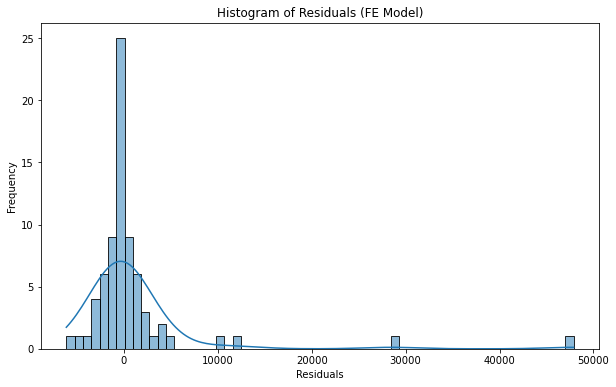

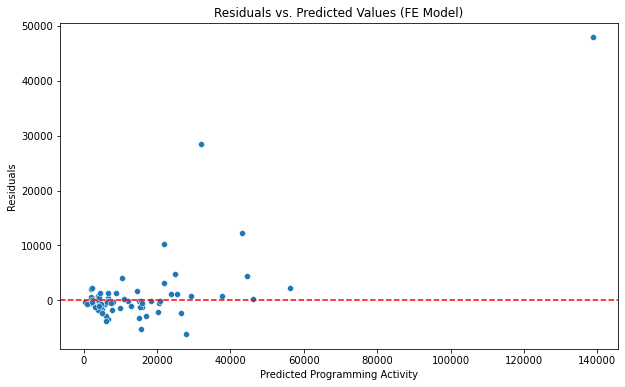

In [125]:
# Descriptive Statistics of Residuals
residual_stats_fe = nuts2_new_df_2016['residuals'].describe()
print("Descriptive Statistics of Residuals:\n", residual_stats_fe)

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(nuts2_new_df_2016['residuals'], kde=True)
plt.title('Histogram of Residuals (FE Model)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Residuals vs Predicted Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=nuts2_new_df_2016['predicted_activity'], y=nuts2_new_df_2016['residuals'])
plt.axhline(0, color='red', linestyle='--')  # Adds a reference line at zero
plt.title('Residuals vs. Predicted Values (FE Model)')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Residuals')
plt.show()

In [126]:
outliers_fe = nuts2_new_df_2016[(nuts2_new_df_2016['residuals'] > 6000) | (nuts2_new_df_2016['residuals'] < -5000)]

# Displaying relevant columns for the outliers
display_columns = ['NUTS2 Region', 'country', 'SE', 'TOTAL', 'HRSTC', 'activity', 'predicted_activity', 'residuals', 'interpretation']
outliers_fe[display_columns]


,NUTS2 Region,country,SE,TOTAL,HRSTC,activity,predicted_activity,residuals,interpretation
8,Région lémanique,CH,95.0,789.0,222.1,32164.20,21958.425000,10205.775000,More
47,Zürich,CH,136.8,849.7,286.0,55306.15,43124.209664,12181.940336,More
138,País Vasco,ES,74.4,901.5,267.0,10446.75,15625.135294,-5178.385294,Fewer
281,Andalucía,ES,170.4,2832.5,585.5,21744.20,27877.842647,-6133.642647,Fewer
346,Ile-de-France,FR,514.8,5303.7,1797.5,186600.05,138718.127731,47881.922269,More
905,Stockholm,SE,167.4,1197.8,448.5,60479.90,32066.328782,28413.571218,More


Outliers are filtered based on the magnitude of the residuals. Here, we consider a residual greater than 6000 or less than -5000 as indicative of a significant deviation from the predicted value.
The identified outliers will help you understand specific regions where the model's predictions deviate substantially from the actual values. Analyzing these outliers can provide insights into whether these deviations are due to anomalies in the data, unusual characteristics of certain regions, or limitations in the model itself.

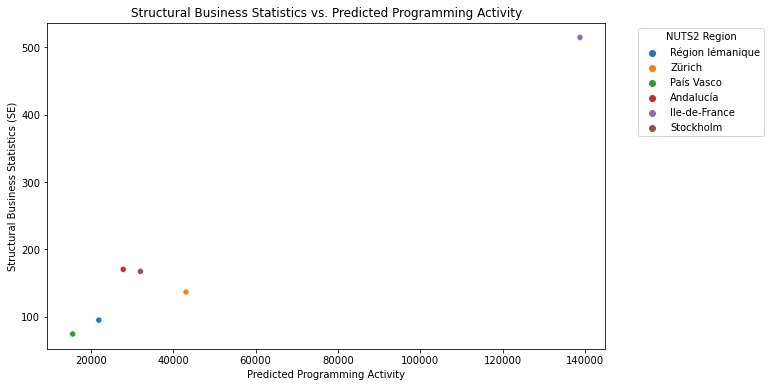

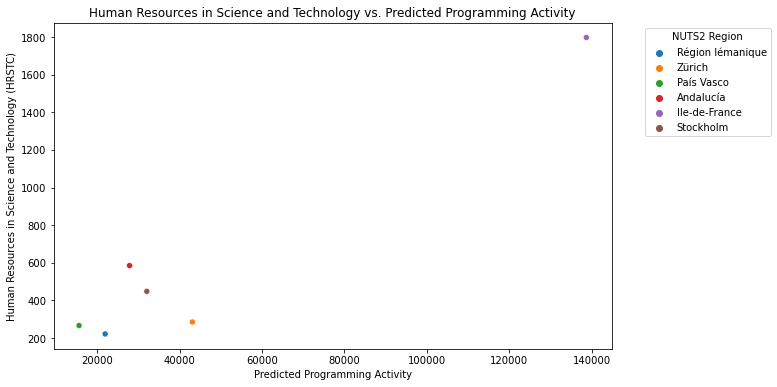

In [127]:
# Scatter Plot: SE vs Predicted Programming Activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers_fe['predicted_activity'], y=outliers_fe['SE'], hue=outliers_fe["NUTS2 Region"])
plt.title('Structural Business Statistics vs. Predicted Programming Activity')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Structural Business Statistics (SE)')
plt.legend(title='NUTS2 Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Scatter Plot: HRSTC vs Predicted Programming Activity
plt.figure(figsize=(10, 6))
sns.scatterplot(x=outliers_fe['predicted_activity'], y=outliers_fe['HRSTC'], hue=outliers_fe["NUTS2 Region"])
plt.title('Human Resources in Science and Technology vs. Predicted Programming Activity')
plt.xlabel('Predicted Programming Activity')
plt.ylabel('Human Resources in Science and Technology (HRSTC)')
plt.legend(title='NUTS2 Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


This plots  show the relationship between the structural business statistics and SE of each region and its predicted programming activity. It can help identify if higher or lower values  are associated with significant prediction deviations (outliers).


These visualizations can provide insights into whether certain characteristics of regions (as represented by 'SE' and 'HRSTC') are associated with larger prediction errors, which could be crucial for understanding the model's performance and potential areas for improvement.